<a href="https://www.mbd.rwth-aachen.de/">
    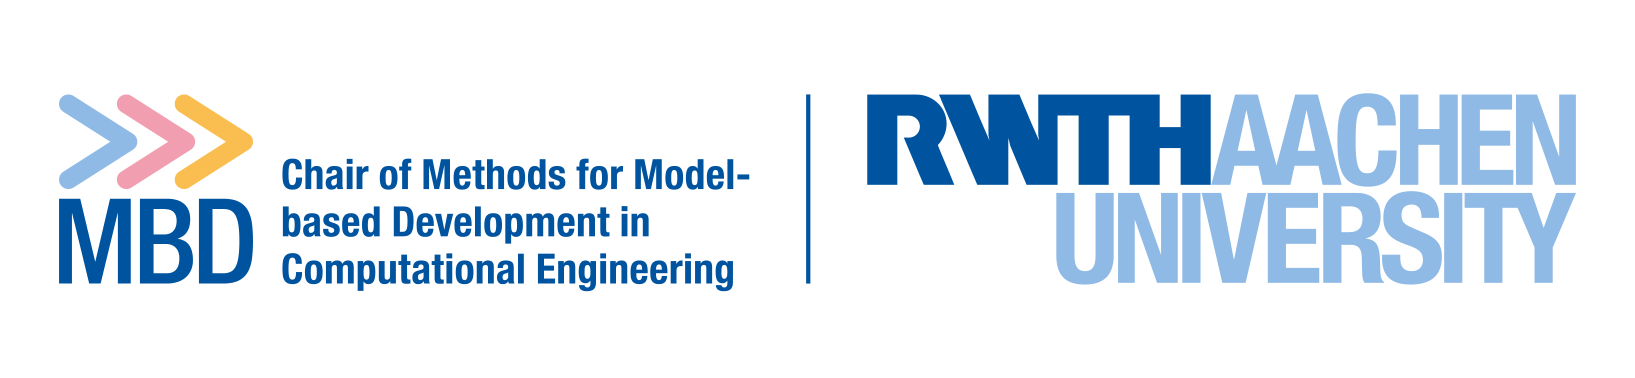
</a>
<a href="https://www.cpbl.rwth-aachen.de/">
    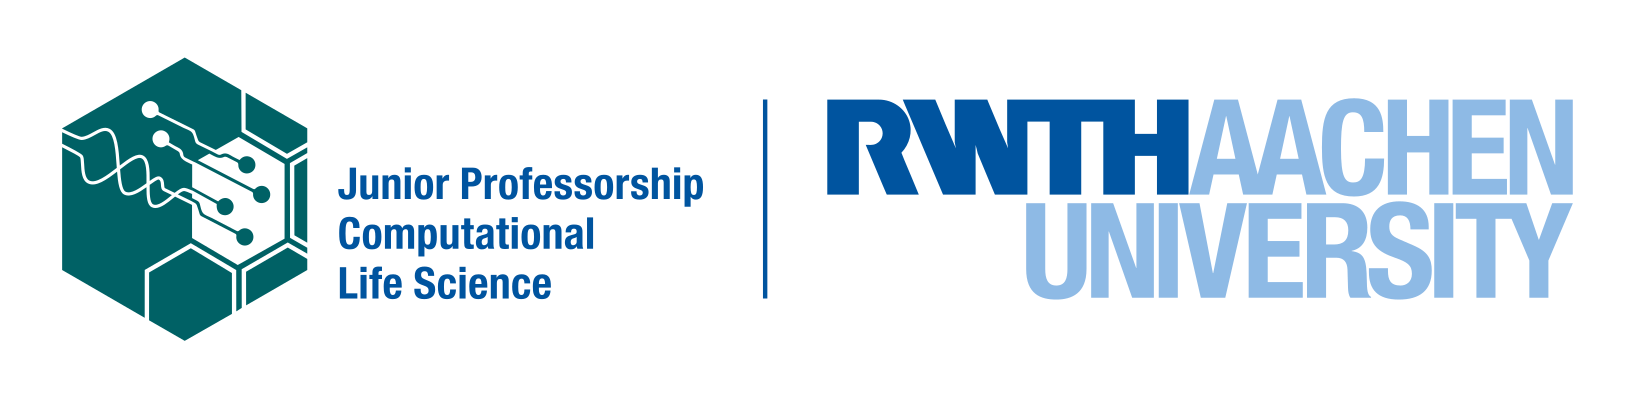
</a>

# Societal Challenges Datathon

Name: Risa Niranjan Chaudhari

Student number (Matrikelnummer): 485510

### Loading Dataset

In [158]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Define helper function to load .xpt dataset
def load_dataset(file_path):
    df = pd.read_sas(file_path, format='xport')
    print(f"Loaded {file_path.split('/')[-1]} with shape {df.shape}")
    return df

# Load all datasets (no renaming yet)
df_diabetes = load_dataset("data/raw/diabetes.xpt")
df_bp = load_dataset("data/raw/blood_pressure_cholesterol.xpt")
df_weight = load_dataset("data/raw/weight_history.xpt")
df_diet = load_dataset("data/raw/diet_behavior_nutrition.xpt")
df_activity = load_dataset("data/raw/physical_activity.xpt")
df_smoking = load_dataset("data/raw/smoking_cigarette_use.xpt")
df_alcohol = load_dataset("data/raw/alcohol_use.xpt")
df_current_health = load_dataset("data/raw/current_health_status.xpt")
df_prescriptions = load_dataset("data/raw/prescription_medications.xpt")

Loaded diabetes.xpt with shape (11744, 9)
Loaded blood_pressure_cholesterol.xpt with shape (8501, 6)
Loaded weight_history.xpt with shape (8501, 5)
Loaded diet_behavior_nutrition.xpt with shape (11933, 27)
Loaded physical_activity.xpt with shape (8153, 8)
Loaded smoking_cigarette_use.xpt with shape (9015, 9)
Loaded alcohol_use.xpt with shape (6337, 9)
Loaded current_health_status.xpt with shape (6615, 2)
Loaded prescription_medications.xpt with shape (11933, 3)


In [159]:
var_map = pd.read_csv("data/extra/variables.csv")

# Show first few rows
print(var_map.head())
# renmame columns based on variable mapping
rename_dict = dict(zip(var_map['Variable Name'], var_map['Renamed_variables']))

df_diabetes.rename(columns=rename_dict, inplace=True)
df_bp.rename(columns=rename_dict, inplace=True)
df_weight.rename(columns=rename_dict, inplace=True)
df_diet.rename(columns=rename_dict, inplace=True)
df_activity.rename(columns=rename_dict, inplace=True)
df_smoking.rename(columns=rename_dict, inplace=True)
df_alcohol.rename(columns=rename_dict, inplace=True)
df_current_health.rename(columns=rename_dict, inplace=True)
df_prescriptions.rename(columns=rename_dict, inplace=True)


  Variable Name                               Variable Description  \
0        AUQ054  These next questions are about {your/SP's} hea...   
1        AUQ101  How often {do you/does SP} have difficulty hea...   
2        AUQ144  A hearing test by a specialist is one that is ...   
3       AUQ410A  What are the main causes of {your/SP's} hearin...   
4       AUQ410B  What are the main causes of {your/SP's} hearin...   

                       Renamed_variables Data File Name Data File Description  \
0                    HearingStatus_NoAid          AUQ_L            Audiometry   
1  DifficultyHearing_WithBackgroundNoise          AUQ_L            Audiometry   
2             LastHearingTest_Specialist          AUQ_L            Audiometry   
3                  reason_hearing_loss_A          AUQ_L            Audiometry   
4                  reason_hearing_loss_B          AUQ_L            Audiometry   

   Begin Year  EndYear      Component Use Constraints Unnamed: 9  
0        2021     2023  Q

In [160]:
print(df_diabetes.columns)
print(df_bp.columns)

Index([                  'sequence_no',             'EverTold_Diabetes',
               'Age_DiabetesDiagnosis',          'EverTold_Prediabetes',
           'BloodSugarTest_Last3Years',       'CurrentlyTaking_Insulin',
                     'InsulinDuration',                             nan,
       'CurrentlyTaking_DiabeticPills'],
      dtype='object')
Index(['sequence_no', 'EverTold_Hypertension', 'ConfirmedHypertension_Visits',
       'CurrentlyTaking_BloodPressureMedication', 'EverTold_HighCholesterol',
       'CurrentlyTaking_CholesterolMedication'],
      dtype='object')


### Filtering  Columns and dataset cleaning

In [161]:
# diabetes dataset cleaning

# dropping empty col
df_diabetes = df_diabetes.loc[:, ~df_diabetes.columns.isna()]

# Binary/categorical columns
binary_cols = [
    'EverTold_Diabetes', 
    'EverTold_Prediabetes', 
    'CurrentlyTaking_Insulin', 
    'CurrentlyTaking_DiabeticPills',
    'BloodSugarTest_Last3Years'
]

# Map binary responses: 1 -> Yes (1), 2 -> No (0), special codes -> NaN
for col in binary_cols:
    df_diabetes[col] = df_diabetes[col].replace({
        1.0: 1.0,          # Yes
        2.0: 2.0,          # No
        3.0: 3.0,      # Borderline / special code
        7.0: pd.NA,      # Refused
        9.0: pd.NA       # Don't know
    })

# Numeric columns
numeric_cols = ['Age_DiabetesDiagnosis', 'InsulinDuration']

# Handle special codes for numeric columns
for col in numeric_cols:
    df_diabetes[col] = df_diabetes[col].replace({666: pd.NA, 777: pd.NA, 999: pd.NA})
    df_diabetes[col] = pd.to_numeric(df_diabetes[col], errors='coerce')

# Logical consistency
# If not diagnosed, age at diagnosis should be NaN
df_diabetes.loc[df_diabetes['EverTold_Diabetes'] == 0, 'Age_DiabetesDiagnosis'] = pd.NA

# If not taking insulin, duration should be NaN
df_diabetes.loc[df_diabetes['CurrentlyTaking_Insulin'] == 0, 'InsulinDuration'] = pd.NA

# filters
df_diabetes = df_diabetes[(df_diabetes['Age_DiabetesDiagnosis'].isna()) | (df_diabetes['Age_DiabetesDiagnosis'] > 0)]
df_diabetes = df_diabetes[(df_diabetes['InsulinDuration'].isna()) | (df_diabetes['InsulinDuration'] >= 0)]

print(df_diabetes.head())



   sequence_no EverTold_Diabetes  Age_DiabetesDiagnosis EverTold_Prediabetes  \
0     130378.0               2.0                    NaN                  2.0   
1     130379.0               2.0                    NaN                  2.0   
2     130380.0               1.0                   35.0                  NaN   
3     130381.0               2.0                    NaN                  NaN   
4     130382.0               2.0                    NaN                  NaN   

  BloodSugarTest_Last3Years  CurrentlyTaking_Insulin  InsulinDuration  \
0                       2.0                      NaN              NaN   
1                       1.0                      NaN              NaN   
2                       NaN                      2.0              NaN   
3                       NaN                      NaN              NaN   
4                       NaN                      NaN              NaN   

  CurrentlyTaking_DiabeticPills  
0                           NaN  
1           

In [162]:
# blood pressure and cholesterol dataset cleaning

#empty col drop
df_bp = df_bp.loc[:, ~df_bp.columns.isna()]

# Binary/categorical columns
binary_cols = [
    'EverTold_Hypertension',
    'ConfirmedHypertension_Visits',
    'CurrentlyTaking_BloodPressureMedication',
    'EverTold_HighCholesterol',
    'CurrentlyTaking_CholesterolMedication'
]

# 1 -> Yes (1), 2 -> No (0), special codes -> NaN
for col in binary_cols:
    df_bp[col] = df_bp[col].replace({
        1.0: 1.0,      # Yes
        2.0: 2.0,      # No
        3.0: 3.0,    # Borderline / special code
        7.0: pd.NA,    # Refused
        9.0: pd.NA     # Don't know
    })




In [163]:
# weight history dataset cleaning

#empty drop col
df_weight = df_weight.loc[:, ~df_weight.columns.isna()]

# Binary/categorical columns
binary_cols = ['TriedToLoseWeight_Past12Months']

# 1 -> Yes (1), 2 -> No (0), special codes -> NaN
for col in binary_cols:
    df_weight[col] = df_weight[col].replace({
        1.0: 1.0,      # Yes
        2.0: 2.0,      # No
        3.0: 3.0,    # Borderline / special code
        7.0: pd.NA,    # Refused
        9.0: pd.NA     # Don't know
    })

# Numeric columns
numeric_cols = ['CurrentHeight', 'CurrentWeight', 'WeightOneYearAgo']

# Handle NHANES special codes in numeric columns
for col in numeric_cols:
    df_weight[col] = df_weight[col].replace({7777: pd.NA, 9999: pd.NA})
    df_weight[col] = pd.to_numeric(df_weight[col], errors='coerce')

In [164]:
# diet behavior and nutrition dataset cleaning

# dropping empty col
df_diet = df_diet.loc[:, ~df_diet.columns.isna()]

# Binary/categorical columns
binary_cols = ['EverBreastfed', 'FirstTypeOfMilkFed_1', 'FirstTypeOfMilkFed_2', 'FirstTypeOfMilkFed_3']

# 1 -> Yes (1), 2 -> No (0), special codes -> NaN
for col in binary_cols:
    df_diet[col] = df_diet[col].replace({
        1.0: 1.0,
        2.0: 2.0,
        3.0: 3.0,
        7.0: pd.NA,
        9.0: pd.NA
    })

# Numeric columns
numeric_cols = [
    'AgeStoppedBreastfeeding', 'AgeFirstFedFormula', 'AgeStoppedDrinkingFormula',
    'AgeFirstFedOtherThanBreastMilk_inDays', 'AgeFirstFedMilk'
]

# Handle special NHANES codes
for col in numeric_cols:
    df_diet[col] = df_diet[col].replace({
        0: 0,          # Still breastfeeding, leave as 0 or optionally NaN
        666666: pd.NA, # More than 3 years
        777777: pd.NA, # Refused
        999999: pd.NA  # Don't know
    })
    df_diet[col] = pd.to_numeric(df_diet[col], errors='coerce')




In [165]:
# smoking dataset cleaning


# Drop empty columns
df_smoking = df_smoking.loc[:, ~df_smoking.columns.isna()]

# Binary/categorical columns
binary_cols = ['SmokedAtLeast100CigarettesInLife', 'SmokingTypeMenthol']

for col in binary_cols:
    df_smoking[col] = df_smoking[col].replace({
        1.0: 1.0,   # Yes
        2.0: 2.0,   # No
        3.0: 3.0,
        7.0: pd.NA, # Refused
        9.0: pd.NA  # Don't know
    })
# CurrentCigaretteSmoking: keep as ordinal
df_smoking['CurrentCigaretteSmoking'] = df_smoking['CurrentCigaretteSmoking'].replace({
    1.0: 1.0,   # Every day
    2.0: 2.0,   # Some days
    3.0: 3.0,   # Not at all
    7.0: pd.NA,
    9.0: pd.NA
})



# Replace special NHANES codes with NaN
df_smoking['CigarettesSmokedDays_30Days'] = df_smoking['CigarettesSmokedDays_30Days'].replace({77: pd.NA, 99: pd.NA})
df_smoking['CigarettesPerDayOnSmokingDays_30Days'] = df_smoking['CigarettesPerDayOnSmokingDays_30Days'].replace({777: pd.NA, 999: pd.NA})
df_smoking['TotalCigarettesSmoked'] = df_smoking['TotalCigarettesSmoked'].replace({77: pd.NA, 99: pd.NA})
df_smoking['TotalCigarettesSmoked'] = pd.to_numeric(df_smoking['TotalCigarettesSmoked'], errors='coerce')
df_smoking['FirstCigaretteAge'] = df_smoking['FirstCigaretteAge'].replace({77: pd.NA, 99: pd.NA})
df_smoking['FirstCigaretteAge'] = pd.to_numeric(df_smoking['FirstCigaretteAge'], errors='coerce')

# filters
df_smoking = df_smoking[(df_smoking['CigarettesSmokedDays_30Days'].isna()) | ((df_smoking['CigarettesSmokedDays_30Days'] >=0) & (df_smoking['CigarettesSmokedDays_30Days'] <=30))]




In [166]:
# current health status dataset cleaning


# Drop empty columns 
df_current_health = df_current_health.loc[:, ~df_current_health.columns.isna()]

# Clean EverTestedFor_AIDS
df_current_health['EverTestedFor_AIDS'] = df_current_health['EverTestedFor_AIDS'].replace({
    1.0: 1.0,      # Yes
    2.0: 2.0,      # No
    7.0: pd.NA,  # Refused
    9.0: pd.NA   # Don't know
})




In [167]:
# cleaning alcohol use dataset


# Drop empty columns
df_alcohol = df_alcohol.loc[:, ~df_alcohol.columns.isna()]

# Binary column: EverHad_Alcohol
df_alcohol['EverHad_Alcohol'] = df_alcohol['EverHad_Alcohol'].replace({
    1.0: 1.0,     # Yes
    2.0: 2.0,     # No
    7.0: pd.NA, # Refused
    9.0: pd.NA  # Don't know
})



### Merging Datasets

In [168]:
# Start with diabetes as base
merged_df = df_diabetes.copy()

# Method 1 : all left joins
for df in [df_bp, df_weight, df_diet, df_activity, df_smoking, df_alcohol, df_current_health]:
    merged_df = merged_df.merge(df, on='sequence_no', how='left')
    print(f"After merging {df.shape[0]} rows, merged dataset shape: {merged_df.shape}")

After merging 8501 rows, merged dataset shape: (11744, 13)
After merging 8501 rows, merged dataset shape: (11744, 17)
After merging 11933 rows, merged dataset shape: (11744, 43)
After merging 8153 rows, merged dataset shape: (11744, 50)
After merging 9015 rows, merged dataset shape: (11744, 58)
After merging 6337 rows, merged dataset shape: (11744, 66)
After merging 6615 rows, merged dataset shape: (11744, 67)


In [ ]:
# Quick overview
print(merged_df.shape)
#print(merged_df_2.shape)




(11744, 67)


In [170]:
# find columns with string data types
string_cols = merged_df.select_dtypes(include=['object']).columns.tolist()
print(string_cols)


# convert string to float if possible else drop
for col in string_cols:
    try:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='raise')
        print(f"Converted column {col} to numeric.")
    except:
        merged_df.drop(columns=[col], inplace=True)
        print(f"Dropping non-numeric column: {col}")

print(merged_df.shape)



['EverTold_Diabetes', 'EverTold_Prediabetes', 'BloodSugarTest_Last3Years', 'CurrentlyTaking_DiabeticPills', 'EverTold_Hypertension', 'ConfirmedHypertension_Visits', 'CurrentlyTaking_BloodPressureMedication', 'EverTold_HighCholesterol', 'CurrentlyTaking_CholesterolMedication', 'TriedToLoseWeight_Past12Months', 'EverBreastfed', 'Frequency_ModerateActivity', 'Frequency_VigorousActivity', 'SmokedAtLeast100CigarettesInLife', 'CigarettesSmokedDays_30Days', 'CigarettesPerDayOnSmokingDays_30Days', 'SmokingTypeMenthol', 'EverHad_Alcohol', 'EverTestedFor_AIDS']
Converted column EverTold_Diabetes to numeric.
Converted column EverTold_Prediabetes to numeric.
Converted column BloodSugarTest_Last3Years to numeric.
Converted column CurrentlyTaking_DiabeticPills to numeric.
Converted column EverTold_Hypertension to numeric.
Converted column ConfirmedHypertension_Visits to numeric.
Converted column CurrentlyTaking_BloodPressureMedication to numeric.
Converted column EverTold_HighCholesterol to numeric.

### Column Classification

In [171]:
categorical_cols = [
    'EverTold_Diabetes',
    'EverTold_Prediabetes',
    'BloodSugarTest_Last3Years',
    'CurrentlyTaking_Insulin',
    'CurrentlyTaking_DiabeticPills',
    'EverTold_Hypertension',
    'ConfirmedHypertension_Visits', 
    'CurrentlyTaking_BloodPressureMedication',
    'EverTold_HighCholesterol',
    'CurrentlyTaking_CholesterolMedication',
    'TriedToLoseWeight_Past12Months',
    'EverBreastfed',
    'FirstTypeOfMilkFed_1',
    'FirstTypeOfMilkFed_2',
    'FirstTypeOfMilkFed_3',
    'FirstTypeOfMilkFed_4',
    'FirstTypeOfMilkFed_5',
    'FirstTypeOfMilkFed_6',
    'MealsDeliveredHome_Past12Months',
    'AttendedCommunityMeals_Past12Months',
    'CurrentlyAttendingSchool',
    'SchoolServesLunches',
    'LunchCostStatus',
    'SchoolServesBreakfastsAtConstantCostsDaily',
    'BreakfastCostStatus',
    'SummerProgramMealCostsStatus',
    'MealPlanningResponsibility',
    'MealPreparationSharing',
    'FoodShoppingResponsibility',
    'FoodShoppingSharing',
    'SmokedAtLeast100CigarettesInLife',
    'CurrentCigaretteSmoking',
    'SmokingTypeMenthol',
    'QuestionnaireModeFlag',
    'EverHad_Alcohol',
    'MoreThan8DrinksPerDay_12Months', # Likely categorical/binary
    'DailyHeavyDrinkingHistory', # Likely categorical/binary
    'OccasionsWithHeavyDrinking_30Days', # Likely categorical/ordinal (e.g., a count treated as a category or a frequency)
    'EverTestedFor_AIDS',
]

len(categorical_cols)

39

In [172]:
numerical_cols = merged_df.columns.difference(categorical_cols).tolist()

len(numerical_cols)

24

In [173]:
# Summary table
missing_summary = merged_df.isna().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary.to_frame(name='Missing (%)')
missing_summary


,Missing (%)
FirstTypeOfMilkFed_4,99.863760
FirstTypeOfMilkFed_5,99.821185
FirstCigaretteAge,99.804155
FirstTypeOfMilkFed_3,99.438011
FirstTypeOfMilkFed_6,99.301771
FirstTypeOfMilkFed_2,98.475817
CigarettesSmokedDays_30Days,97.717984
InsulinDuration,97.173025
TotalCigarettesSmoked,93.434946
FirstTypeOfMilkFed_1,92.668597


### Removing Missing data

In [174]:
# remove data that has morethan 90% missing values
cols_to_drop = missing_summary[missing_summary['Missing (%)'] > 99].index.tolist()
merged_df.drop(columns=cols_to_drop, inplace=True)

print(cols_to_drop)

# update numerical_cols after dropping
numerical_cols = merged_df.columns.difference(categorical_cols).tolist()
categorical_cols = merged_df.columns.difference(numerical_cols).tolist()

['FirstTypeOfMilkFed_4', 'FirstTypeOfMilkFed_5', 'FirstCigaretteAge', 'FirstTypeOfMilkFed_3', 'FirstTypeOfMilkFed_6']


In [175]:
import pandas as pd

# Show all rows in the DataFrame output
pd.set_option('display.max_rows', None)

missing_summary = merged_df.isna().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary.to_frame(name='Missing (%)')
missing_summary


,Missing (%)
FirstTypeOfMilkFed_2,98.475817
CigarettesSmokedDays_30Days,97.717984
InsulinDuration,97.173025
TotalCigarettesSmoked,93.434946
FirstTypeOfMilkFed_1,92.668597
AgeStoppedBreastfeeding,91.927793
AgeStoppedDrinkingFormula,91.774523
Age_DiabetesDiagnosis,90.999659
CurrentlyTaking_Insulin,90.795300
SmokingTypeMenthol,90.020436


In [176]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Imputing Missing Values

In [177]:
# ---------------------------
# 3. Verify no missing values remain
# ---------------------------
print("Missing values before imputation:")
print(merged_df.isna().sum())

Missing values before imputation:
sequence_no                                          0
EverTold_Diabetes                                    8
Age_DiabetesDiagnosis                            10687
EverTold_Prediabetes                              3737
BloodSugarTest_Last3Years                         3707
CurrentlyTaking_Insulin                          10663
InsulinDuration                                  11412
CurrentlyTaking_DiabeticPills                     9470
EverTold_Hypertension                             3257
ConfirmedHypertension_Visits                      8802
CurrentlyTaking_BloodPressureMedication           8779
EverTold_HighCholesterol                          3300
CurrentlyTaking_CholesterolMedication             3279
CurrentHeight                                     3330
CurrentWeight                                     3386
WeightOneYearAgo                                  3472
TriedToLoseWeight_Past12Months                    3262
EverBreastfed                  

#### Numerical Columns


Analyzing column: AgeFirstFedFormula
AgeFirstFedFormula: 6.03% outliers
  -> Using median imputation


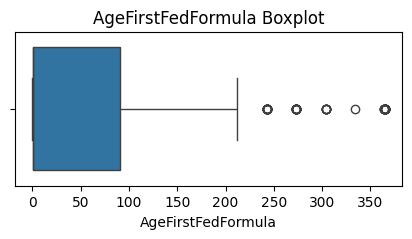


Analyzing column: AgeFirstFedMilk
AgeFirstFedMilk: 37.66% outliers
  -> Using median imputation


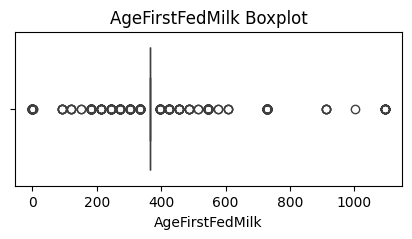


Analyzing column: AgeFirstFedOtherThanBreastMilk_inDays
AgeFirstFedOtherThanBreastMilk_inDays: 5.48% outliers
  -> Using median imputation


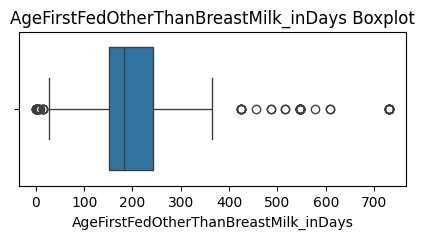


Analyzing column: AgeStoppedBreastfeeding
AgeStoppedBreastfeeding: 3.16% outliers
  -> Using mean imputation


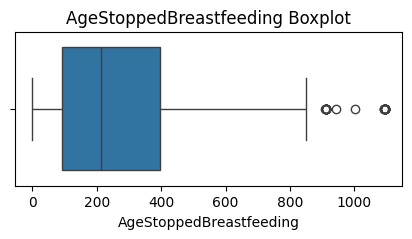


Analyzing column: AgeStoppedDrinkingFormula
AgeStoppedDrinkingFormula: 40.99% outliers
  -> Using median imputation


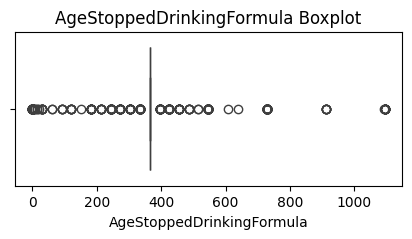


Analyzing column: Age_DiabetesDiagnosis
Age_DiabetesDiagnosis: 1.23% outliers
  -> Using mean imputation


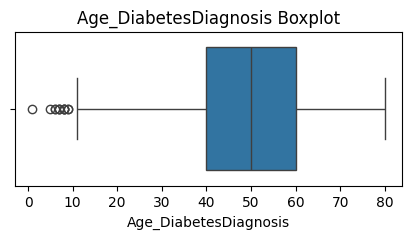


Analyzing column: AlcoholConsumptionFrequency_12Months
AlcoholConsumptionFrequency_12Months: 0.10% outliers
  -> Using mean imputation


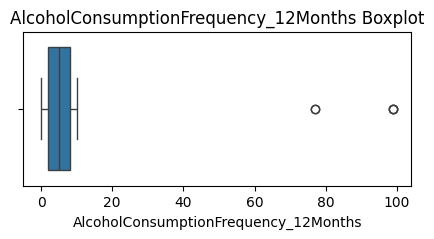


Analyzing column: AverageDrinksPerDrinkingDay_12Months
AverageDrinksPerDrinkingDay_12Months: 5.04% outliers
  -> Using median imputation


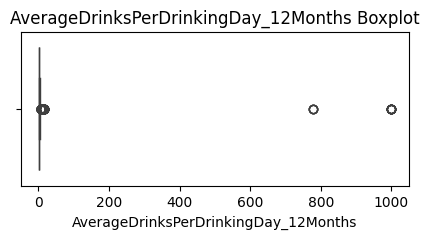


Analyzing column: CigarettesPerDayOnSmokingDays_30Days
CigarettesPerDayOnSmokingDays_30Days: 3.15% outliers
  -> Using mean imputation


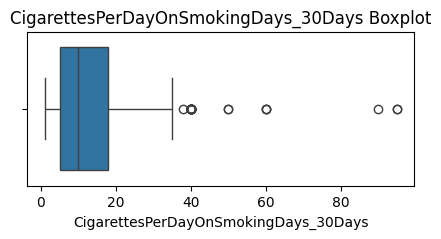


Analyzing column: CigarettesSmokedDays_30Days
CigarettesSmokedDays_30Days: 0.00% outliers
  -> Using mean imputation


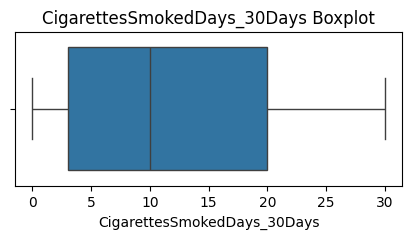


Analyzing column: CurrentHeight
CurrentHeight: 0.31% outliers
  -> Using mean imputation


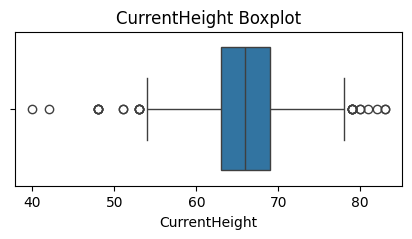


Analyzing column: CurrentWeight
CurrentWeight: 2.48% outliers
  -> Using mean imputation


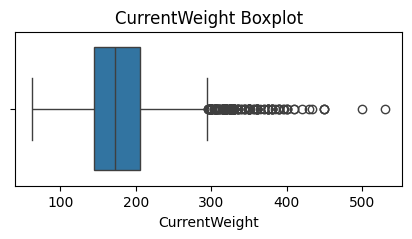


Analyzing column: Duration_ModerateActivity_PerSession
Duration_ModerateActivity_PerSession: 16.78% outliers
  -> Using median imputation


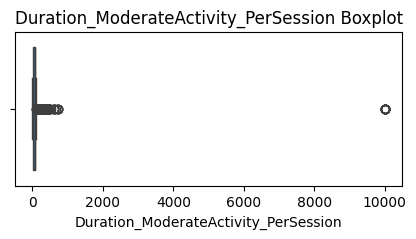


Analyzing column: Duration_VigorousActivity_PerSession
Duration_VigorousActivity_PerSession: 15.43% outliers
  -> Using median imputation


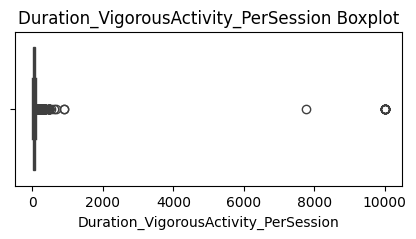


Analyzing column: HeavyDrinkingWithinTwoHoursFrequency_12Months
HeavyDrinkingWithinTwoHoursFrequency_12Months: 0.55% outliers
  -> Using mean imputation


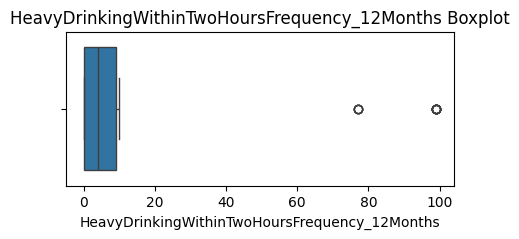


Analyzing column: InsulinDuration
InsulinDuration: 6.33% outliers
  -> Using median imputation


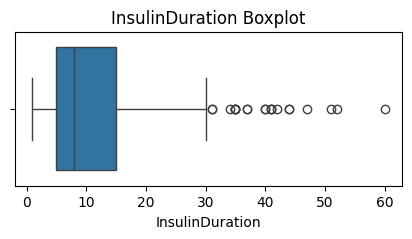


Analyzing column: MoreThanSpecificNumberOfDrinksFrequency
MoreThanSpecificNumberOfDrinksFrequency: 0.49% outliers
  -> Using mean imputation


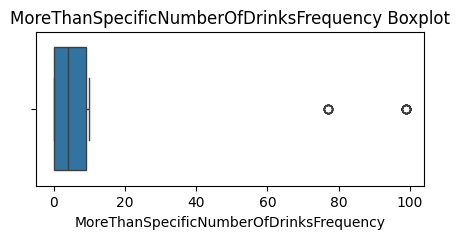


Analyzing column: NumberWeeklyCompleteSchoolBreakfasts
NumberWeeklyCompleteSchoolBreakfasts: 0.97% outliers
  -> Using mean imputation


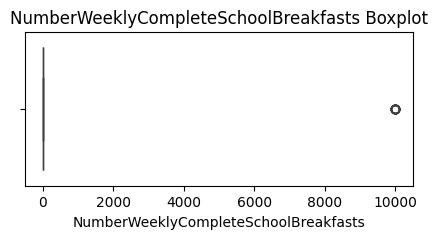


Analyzing column: NumberWeeklyCompleteSchoolLunches
NumberWeeklyCompleteSchoolLunches: 0.79% outliers
  -> Using mean imputation


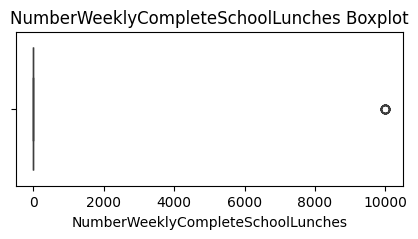


Analyzing column: SittingTime_TypicalDay
SittingTime_TypicalDay: 2.27% outliers
  -> Using mean imputation


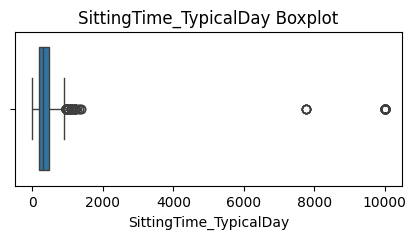


Analyzing column: TotalCigarettesSmoked
TotalCigarettesSmoked: 6.61% outliers
  -> Using median imputation


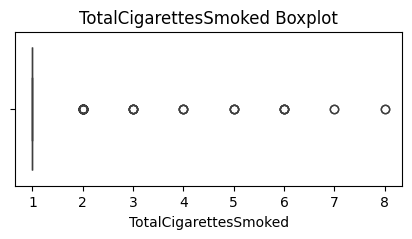


Analyzing column: WeightOneYearAgo
WeightOneYearAgo: 2.09% outliers
  -> Using mean imputation


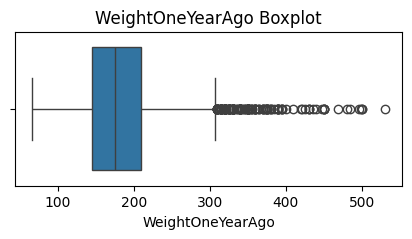


Analyzing column: sequence_no
sequence_no: 0.00% outliers
  -> Using mean imputation


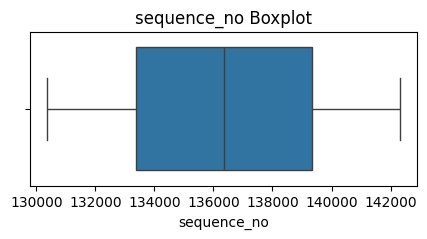


✅ Numeric columns imputed successfully.



In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


# Dictionary to store chosen imputation strategy
imputation_strategy = {}

for col in numerical_cols:
    # Ensure numeric dtype and replace pd.NA with np.nan
    if col not in merged_df.columns:
        print(f"{col} not in merged_df columns, skipping.")
        continue
    
    print(f"\nAnalyzing column: {col}")
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    
    data = merged_df[col]
    
    # Simple outlier detection using 1.5*IQR rule
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
    outlier_pct = len(outliers)/len(data.dropna())*100
    
    print(f"{col}: {outlier_pct:.2f}% outliers")
    
    # Choose strategy
    if outlier_pct > 5:  # significant outliers → use median
        strategy = 'median'
    else:
        strategy = 'mean'
        
    imputation_strategy[col] = strategy
    print(f"  -> Using {strategy} imputation")
    
    # Optional: boxplot for visualization
    plt.figure(figsize=(5,2))
    sns.boxplot(x=data)
    plt.title(f"{col} Boxplot")
    plt.show()

# Impute numeric columns
for col, strategy in imputation_strategy.items():
    imp = SimpleImputer(strategy=strategy)
    merged_df[[col]] = imp.fit_transform(merged_df[[col]])

print("\n✅ Numeric columns imputed successfully.\n")

#### Categorical Columns

In [179]:

# Identify categorical columns present in merged_df
categorical_existing = [col for col in categorical_cols if col in merged_df.columns]

for col in categorical_existing:
    # Replace pd.NA with np.nan
    merged_df[col] = merged_df[col].replace({pd.NA: np.nan})
    
    data = merged_df[col]
    
    # Compute missing percentage
    missing_pct = data.isna().mean() * 100
    
    # Distribution of categories (excluding missing)
    value_counts = (data.value_counts(normalize=True, dropna=True) * 100).to_frame(name="Percentage (%)")
    
    print(f"\nColumn: {col}, Missing: {missing_pct:.2f}%")
    display(value_counts)
    
    if missing_pct > 0:
        # If top category dominates (>80%), fill with most frequent
        if value_counts.iloc[0, 0] > 80:
            fill_value = value_counts.index[0]
            merged_df[col] = data.fillna(fill_value)
            print(f"  -> Using Most Frequent Imputation: {fill_value}")
        else:
            # Fill missing with 4.0 instead of "Missing" string
            merged_df[col] = data.fillna(4.0)
            print(f"  -> Using '4.0' for missing values")
    else:
        print("  -> No missing, no imputation needed")

print("\n✅ Categorical columns imputed successfully.\n")


Column: AttendedCommunityMeals_Past12Months, Missing: 70.20%


,Percentage (%)
AttendedCommunityMeals_Past12Months,
2.0,97.257143
1.0,2.714286
9.0,0.028571


  -> Using Most Frequent Imputation: 2.0

Column: BloodSugarTest_Last3Years, Missing: 31.57%


,Percentage (%)
BloodSugarTest_Last3Years,
2.0,58.068931
1.0,41.931069


  -> Using '4.0' for missing values

Column: BreakfastCostStatus, Missing: 88.08%


,Percentage (%)
BreakfastCostStatus,
1.0,87.857143
3.0,7.500000
2.0,4.214286
9.0,0.428571


  -> Using Most Frequent Imputation: 1.0

Column: ConfirmedHypertension_Visits, Missing: 74.95%


,Percentage (%)
ConfirmedHypertension_Visits,
1.0,83.888511
2.0,16.111489


  -> Using Most Frequent Imputation: 1.0

Column: CurrentCigaretteSmoking, Missing: 72.39%


,Percentage (%)
CurrentCigaretteSmoking,
3.0,63.305581
1.0,29.355535
2.0,7.338884


  -> Using '4.0' for missing values

Column: CurrentlyAttendingSchool, Missing: 71.42%


,Percentage (%)
CurrentlyAttendingSchool,
1.0,82.275842
2.0,17.664581
9.0,0.029789
7.0,0.029789


  -> Using Most Frequent Imputation: 1.0

Column: CurrentlyTaking_BloodPressureMedication, Missing: 74.75%


,Percentage (%)
CurrentlyTaking_BloodPressureMedication,
1.0,82.360877
2.0,17.639123


  -> Using Most Frequent Imputation: 1.0

Column: CurrentlyTaking_CholesterolMedication, Missing: 27.92%


,Percentage (%)
CurrentlyTaking_CholesterolMedication,
2.0,74.88482
1.0,25.11518


  -> Using '4.0' for missing values

Column: CurrentlyTaking_DiabeticPills, Missing: 80.64%


,Percentage (%)
CurrentlyTaking_DiabeticPills,
2.0,61.081794
1.0,38.918206


  -> Using '4.0' for missing values

Column: CurrentlyTaking_Insulin, Missing: 90.80%


,Percentage (%)
CurrentlyTaking_Insulin,
2.0,68.177613
1.0,31.822387


  -> Using '4.0' for missing values

Column: DailyHeavyDrinkingHistory, Missing: 58.27%


,Percentage (%)
DailyHeavyDrinkingHistory,
2.0,81.187513
1.0,18.690063
9.0,0.102020
7.0,0.020404


  -> Using Most Frequent Imputation: 2.0

Column: EverBreastfed, Missing: 89.38%


,Percentage (%)
EverBreastfed,
1.0,76.744186
2.0,23.255814


  -> Using '4.0' for missing values

Column: EverHad_Alcohol, Missing: 53.37%


,Percentage (%)
EverHad_Alcohol,
1.0,89.81008
2.0,10.18992


  -> Using Most Frequent Imputation: 1.0

Column: EverTestedFor_AIDS, Missing: 51.12%


,Percentage (%)
EverTestedFor_AIDS,
2.0,71.189688
1.0,28.810312


  -> Using '4.0' for missing values

Column: EverTold_Diabetes, Missing: 0.07%


,Percentage (%)
EverTold_Diabetes,
2.0,88.369121
1.0,9.210975
3.0,2.419905


  -> Using Most Frequent Imputation: 2.0

Column: EverTold_HighCholesterol, Missing: 28.10%


,Percentage (%)
EverTold_HighCholesterol,
2.0,63.334912
1.0,36.665088


  -> Using '4.0' for missing values

Column: EverTold_Hypertension, Missing: 27.73%


,Percentage (%)
EverTold_Hypertension,
2.0,65.017085
1.0,34.982915


  -> Using '4.0' for missing values

Column: EverTold_Prediabetes, Missing: 31.82%


,Percentage (%)
EverTold_Prediabetes,
2.0,88.535032
1.0,11.464968


  -> Using Most Frequent Imputation: 2.0

Column: FirstTypeOfMilkFed_1, Missing: 92.67%


,Percentage (%)
FirstTypeOfMilkFed_1,
10.0,99.186992
99.0,0.813008


  -> Using Most Frequent Imputation: 10.0

Column: FirstTypeOfMilkFed_2, Missing: 98.48%


,Percentage (%)
FirstTypeOfMilkFed_2,
11.0,100.0


  -> Using Most Frequent Imputation: 11.0

Column: FoodShoppingResponsibility, Missing: 27.74%


,Percentage (%)
FoodShoppingResponsibility,
1.0,64.836201
2.0,35.140231
9.0,0.023568


  -> Using '4.0' for missing values

Column: FoodShoppingSharing, Missing: 27.74%


,Percentage (%)
FoodShoppingSharing,
1.0,50.542069
2.0,49.434362
9.0,0.023568


  -> Using '4.0' for missing values

Column: LunchCostStatus, Missing: 81.62%


,Percentage (%)
LunchCostStatus,
1.0,74.664196
3.0,20.240852
2.0,4.678092
9.0,0.416860


  -> Using '4.0' for missing values

Column: MealPlanningResponsibility, Missing: 27.74%


,Percentage (%)
MealPlanningResponsibility,
1.0,64.965826
2.0,34.998822
9.0,0.035352


  -> Using '4.0' for missing values

Column: MealPreparationSharing, Missing: 27.74%


,Percentage (%)
MealPreparationSharing,
1.0,50.353523
2.0,49.634692
9.0,0.011784


  -> Using '4.0' for missing values

Column: MealsDeliveredHome_Past12Months, Missing: 70.20%


,Percentage (%)
MealsDeliveredHome_Past12Months,
2.0,95.028571
1.0,4.971429


  -> Using Most Frequent Imputation: 2.0

Column: MoreThan8DrinksPerDay_12Months, Missing: 79.89%


,Percentage (%)
MoreThan8DrinksPerDay_12Months,
5.397605e-79,58.890771
1.000000e+01,15.707028
7.000000e+00,5.165114
9.000000e+00,4.826418
6.000000e+00,3.471634
8.000000e+00,3.386960
5.000000e+00,3.132938
4.000000e+00,2.074513
3.000000e+00,1.524132


  -> Using '4.0' for missing values

Column: OccasionsWithHeavyDrinking_30Days, Missing: 79.92%


,Percentage (%)
OccasionsWithHeavyDrinking_30Days,
5.397605e-79,47.879559
1.000000e+00,19.720102
2.000000e+00,11.577608
3.000000e+00,6.022053
4.000000e+00,3.859203
5.000000e+00,2.756573
3.000000e+01,1.823579
6.000000e+00,1.314673
2.000000e+01,1.314673


  -> Using '4.0' for missing values

Column: QuestionnaireModeFlag, Missing: 23.24%


,Percentage (%)
QuestionnaireModeFlag,
1.0,90.438159
2.0,9.561841


  -> Using Most Frequent Imputation: 1.0

Column: SchoolServesBreakfastsAtConstantCostsDaily, Missing: 76.48%


,Percentage (%)
SchoolServesBreakfastsAtConstantCostsDaily,
1.0,86.097031
2.0,10.789283
9.0,3.077480
7.0,0.036206


  -> Using Most Frequent Imputation: 1.0

Column: SchoolServesLunches, Missing: 76.48%


,Percentage (%)
SchoolServesLunches,
1.0,95.691528
2.0,4.199855
9.0,0.072411
7.0,0.036206


  -> Using Most Frequent Imputation: 1.0

Column: SmokedAtLeast100CigarettesInLife, Missing: 30.85%


,Percentage (%)
SmokedAtLeast100CigarettesInLife,
2.0,60.066494
1.0,39.933506


  -> Using '4.0' for missing values

Column: SmokingTypeMenthol, Missing: 90.02%


,Percentage (%)
SmokingTypeMenthol,
5.397605e-79,60.750853
1.000000e+00,39.249147


  -> Using '4.0' for missing values

Column: SummerProgramMealCostsStatus, Missing: 84.84%


,Percentage (%)
SummerProgramMealCostsStatus,
2.0,42.696629
3.0,29.775281
1.0,26.966292
9.0,0.561798


  -> Using '4.0' for missing values

Column: TriedToLoseWeight_Past12Months, Missing: 27.78%


,Percentage (%)
TriedToLoseWeight_Past12Months,
2.0,54.550813
1.0,45.449187


  -> Using '4.0' for missing values

✅ Categorical columns imputed successfully.



In [180]:
# ---------------------------
# 3. Verify no missing values remain
# ---------------------------
print("Missing values after imputation:")
print(merged_df.isna().sum())

Missing values after imputation:
sequence_no                                      0
EverTold_Diabetes                                0
Age_DiabetesDiagnosis                            0
EverTold_Prediabetes                             0
BloodSugarTest_Last3Years                        0
CurrentlyTaking_Insulin                          0
InsulinDuration                                  0
CurrentlyTaking_DiabeticPills                    0
EverTold_Hypertension                            0
ConfirmedHypertension_Visits                     0
CurrentlyTaking_BloodPressureMedication          0
EverTold_HighCholesterol                         0
CurrentlyTaking_CholesterolMedication            0
CurrentHeight                                    0
CurrentWeight                                    0
WeightOneYearAgo                                 0
TriedToLoseWeight_Past12Months                   0
EverBreastfed                                    0
AgeStoppedBreastfeeding                          

### Diabetes - Target Variable

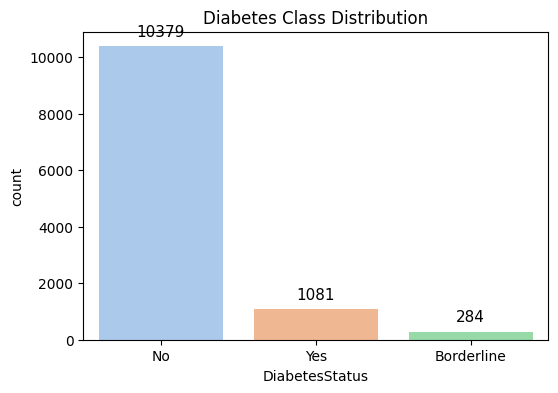

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map numeric codes + pd.NA to strings
diabetes_map = {
    1: "Yes",
    2: "No",
    3: "Borderline"
}

merged_df['DiabetesStatus'] = merged_df['EverTold_Diabetes'].apply(
    lambda x: diabetes_map.get(int(x), "Missing") if pd.notna(x) else "Missing"
)

plt.figure(figsize=(6,4))
ax = sns.countplot(x='DiabetesStatus', data=merged_df, palette='pastel')
plt.title("Diabetes Class Distribution")

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                xy=(p.get_x() + p.get_width() / 2, height), 
                xytext=(0, 5),  # 5 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=11)

plt.show()

### EDA

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

#### Univariate

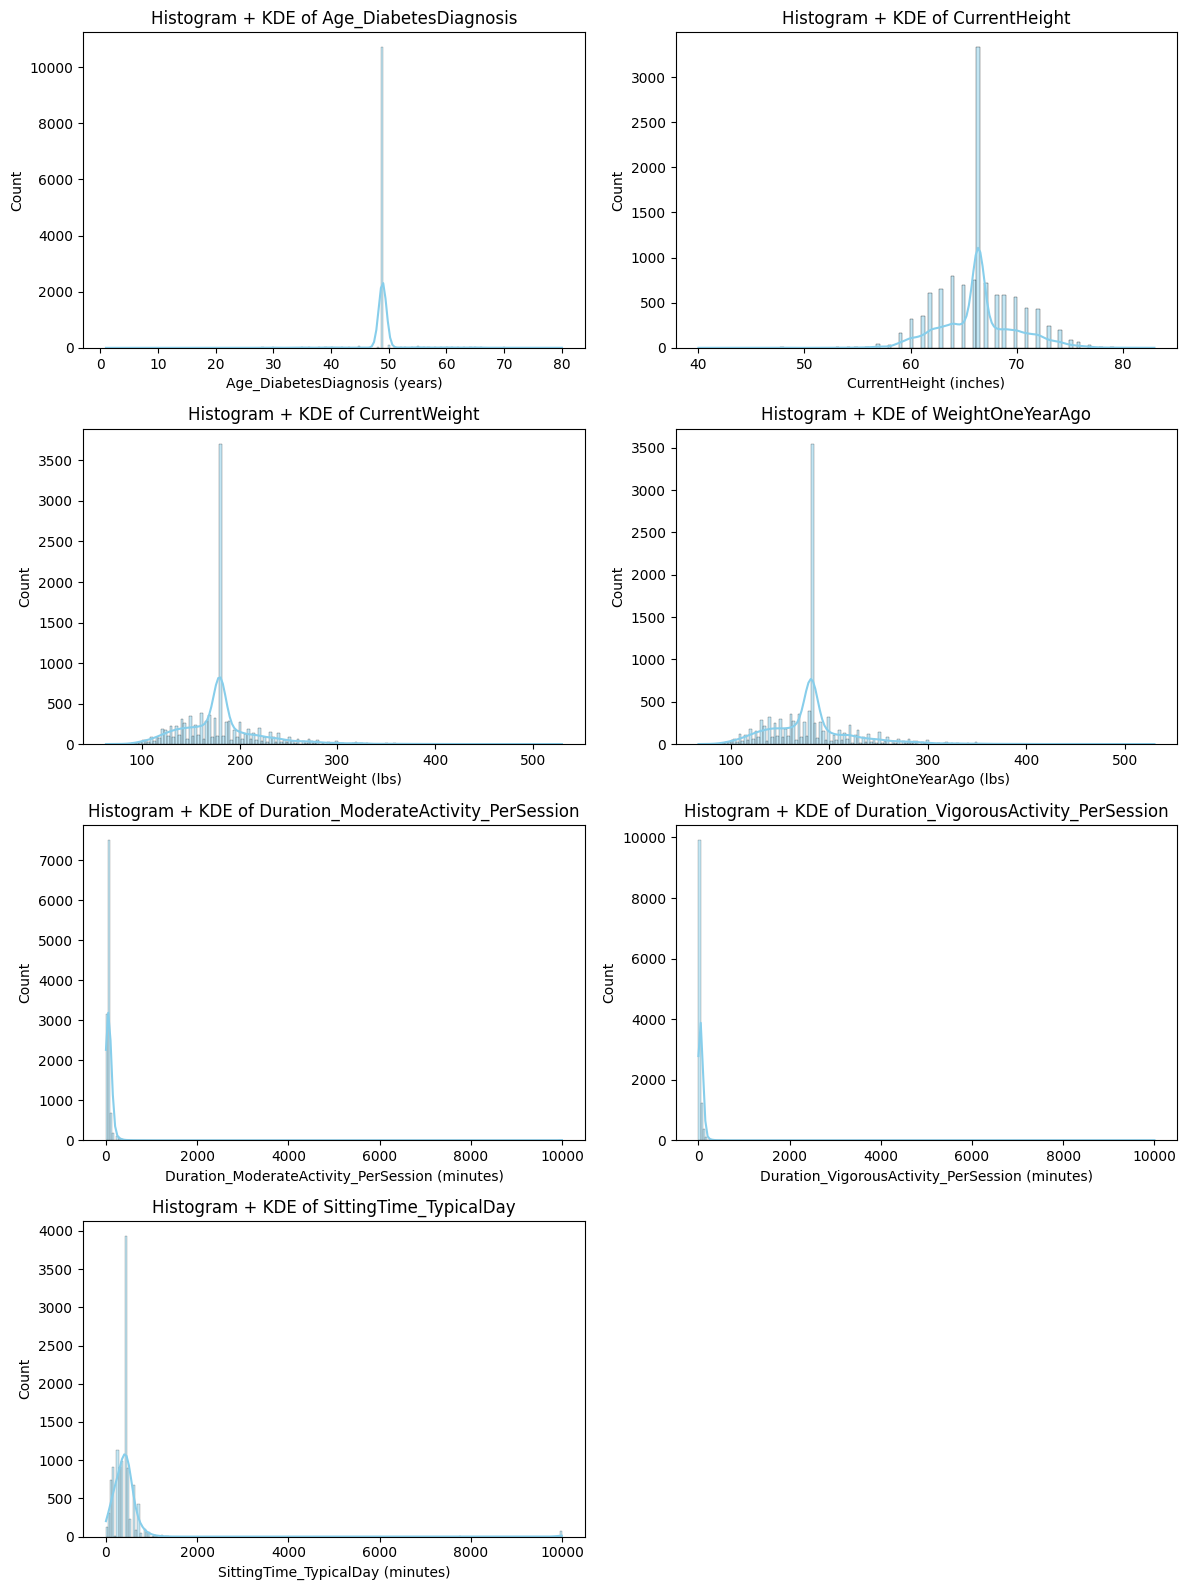

In [183]:

# univaraiate analysis of numeric variables
# Numeric variables
numeric_cols = ['Age_DiabetesDiagnosis', 'CurrentHeight', 'CurrentWeight', 
                'WeightOneYearAgo', 'Duration_ModerateActivity_PerSession', 
                'Duration_VigorousActivity_PerSession', 'SittingTime_TypicalDay']

# Define units for each column (fill according to dataset documentation or logical guess)
# Example units dictionary
units = {
    'Age_DiabetesDiagnosis': 'years',
    'CurrentHeight': 'inches',
    'CurrentWeight': 'lbs',
    'WeightOneYearAgo': 'lbs',
    'Duration_ModerateActivity_PerSession': 'minutes',
    'Duration_VigorousActivity_PerSession': 'minutes',
    'SittingTime_TypicalDay': 'minutes'
}

# numeric variables
numeric_cols = list(units.keys())

# Determine number of rows needed for 2-column grid
n_cols = 2
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # flatten for easy indexing

for i, col in enumerate(numeric_cols):
    sns.histplot(merged_df[col].dropna(), kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Histogram + KDE of {col}')
    axes[i].set_xlabel(f'{col} ({units[col]})')  # add unit here

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

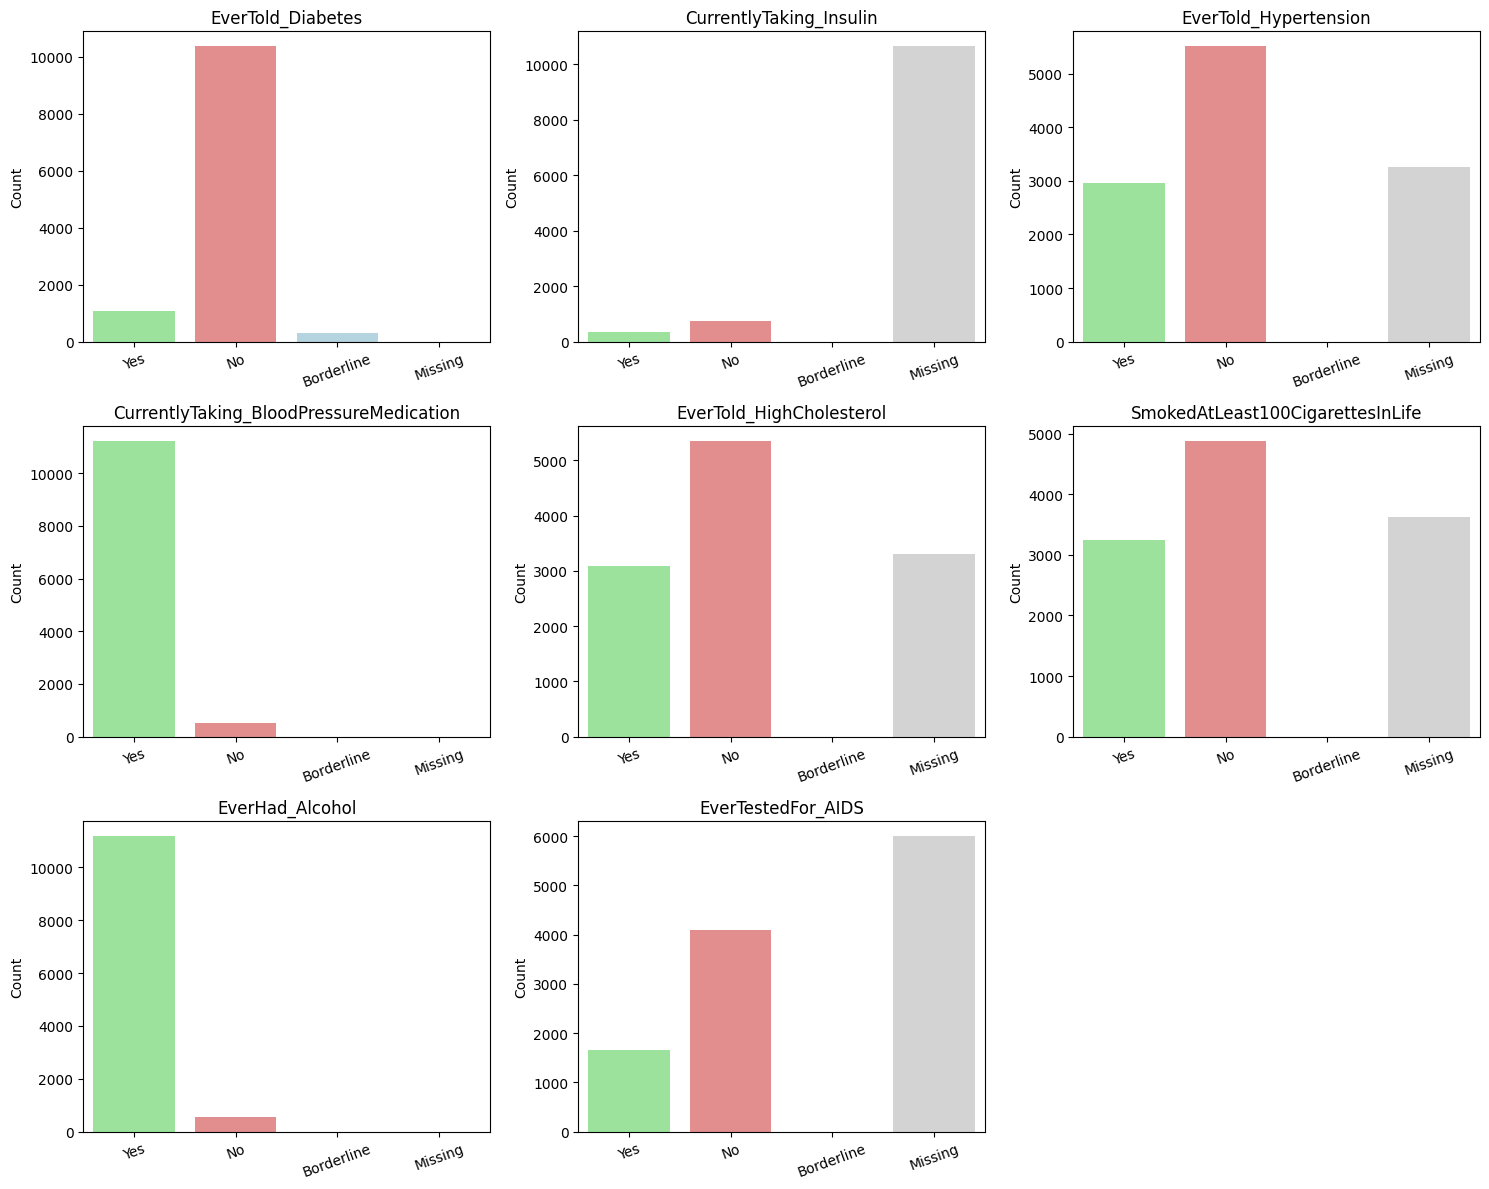

In [184]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical variables (adjust list as needed)
categorical_cols = [
    'EverTold_Diabetes', 'CurrentlyTaking_Insulin', 'EverTold_Hypertension',
    'CurrentlyTaking_BloodPressureMedication', 'EverTold_HighCholesterol',
    'SmokedAtLeast100CigarettesInLife', 'EverHad_Alcohol',
    'EverTestedFor_AIDS'
]

# Keep only columns that exist in merged_df
existing_cols = [col for col in categorical_cols if col in merged_df.columns]

# plotting grid
n_cols = 3
n_rows = math.ceil(len(existing_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Map numeric codes to labels (1 -> Yes, 2 -> No, 3 -> Borderline)
value_map = {
    1: "Yes",
    2: "No",
    3: "Borderline"
}

# Color mapping for labels
color_map = {
    "Yes": "lightgreen",
    "No": "lightcoral",
    "Borderline": "lightblue",
    "Missing": "lightgray",
    # Optional: if you expect "Other(...)" labels you can add a color for them
}

def map_label(x):
    # Convert pd.NA / NaN -> Missing
    if pd.isna(x):
        return "Missing"
    # Try to cast to int for float-coded categories (e.g., 1.0)
    try:
        xi = int(x)
    except Exception:
        # If casting fails, mark as Missing or Other
        return "Missing"
    return value_map.get(xi, "Missing")

for i, col in enumerate(existing_cols):
    mapped_series = merged_df[col].apply(map_label)
    
    # Define desired category order for consistent plots
    desired_order = ["Yes", "No", "Borderline", "Missing"]
    value_counts = mapped_series.value_counts().reindex(desired_order, fill_value=0)
    
    # Build colors for present categories only (in same order)
    colors = [color_map[label] for label in value_counts.index]
    
    # Plot
    sns.barplot(
        x=value_counts.index,
        y=value_counts.values,
        palette=colors,
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    # rotate xlabels for readability if needed
    axes[i].tick_params(axis='x', rotation=20)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Bivariate

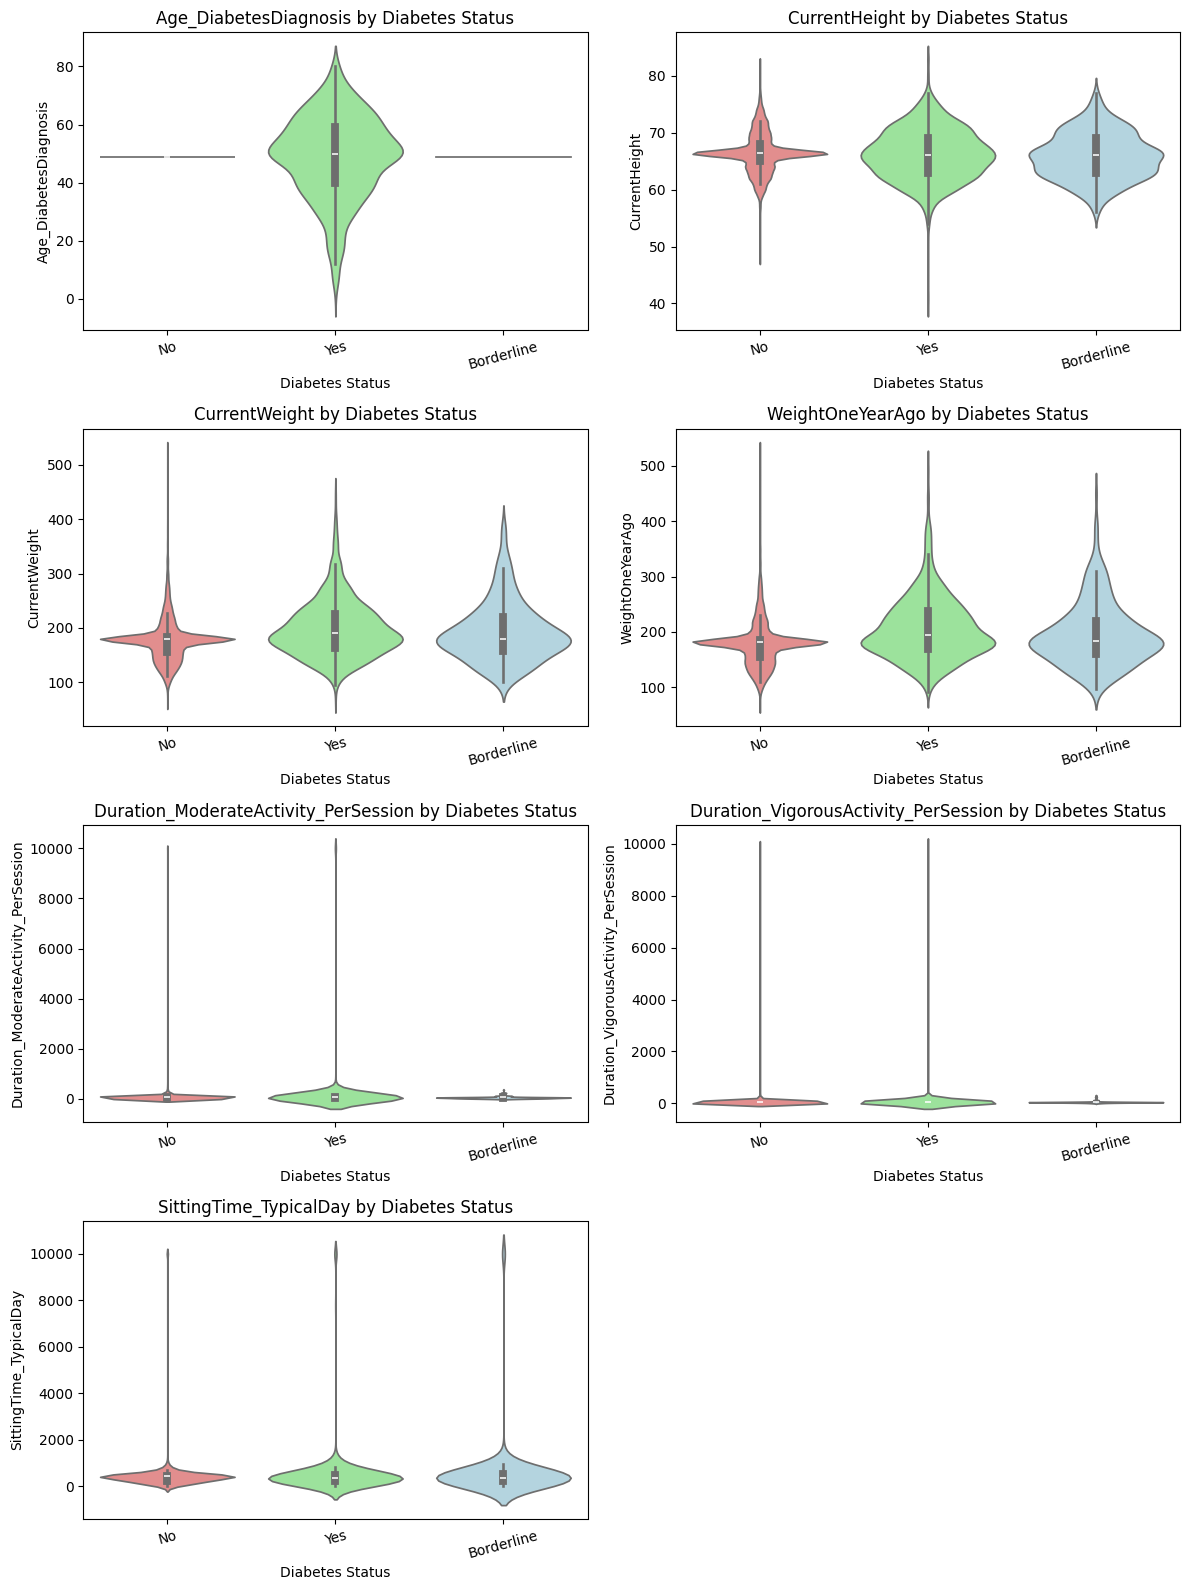

In [185]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping of diabetes status
diabetes_map = {1: "Yes", 2: "No", 3: "Borderline"}

# Prepare data
df_plot = merged_df.dropna(subset=['EverTold_Diabetes']).copy()
df_plot['DiabetesStatus'] = df_plot['EverTold_Diabetes'].apply(
    lambda x: diabetes_map.get(int(x), "Missing") if not pd.isna(x) else "Missing"
)

# Keep only numeric columns that exist
existing_cols = [col for col in numeric_cols if col in df_plot.columns]

# Grid size
n_cols = 2
n_rows = math.ceil(len(existing_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Define consistent colors
palette = {
    "Yes": "lightgreen",
    "No": "lightcoral",
    "Borderline": "lightblue",
    "Missing": "lightgray"
}

for i, col in enumerate(existing_cols):
    sns.violinplot(
        data=df_plot,
        x="DiabetesStatus",
        y=col,
        palette=palette,
        inner='box',
        ax=axes[i]
    )

    axes[i].set_title(f"{col} by Diabetes Status")
    axes[i].set_xlabel("Diabetes Status")
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=15)

# Remove empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


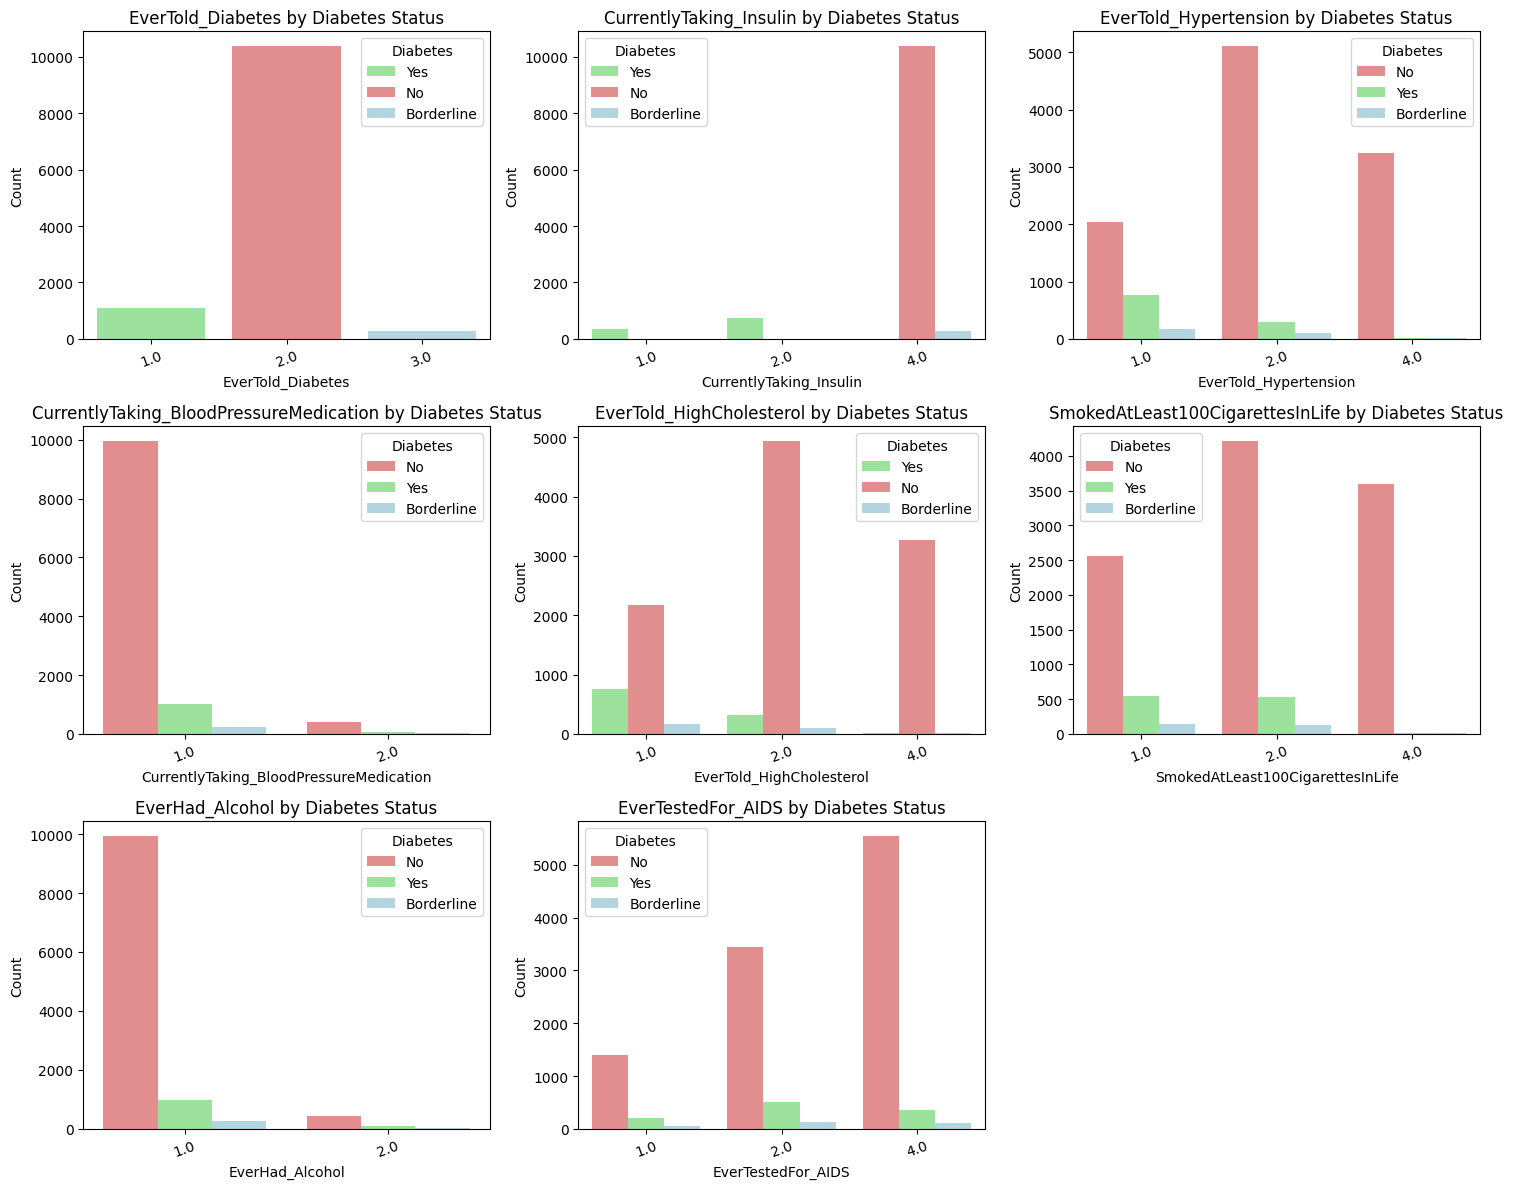

In [186]:
# Mapping
diabetes_map = {1: "Yes", 2: "No", 3: "Borderline"}

# Colors for hue
palette = {
    "Yes": "lightgreen",
    "No": "lightcoral",
    "Borderline": "lightblue"
}

# Keep columns that exist
existing_cols = [col for col in categorical_cols if col in merged_df.columns]

n_cols = 3
n_rows = math.ceil(len(existing_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(existing_cols):

    df_plot = merged_df.dropna(subset=['EverTold_Diabetes', col]).copy()
    
    # Apply mapping
    df_plot['DiabetesStatus'] = df_plot['EverTold_Diabetes'].apply(
        lambda x: diabetes_map.get(int(x), "Missing")
    )

    sns.countplot(
        data=df_plot,
        x=col,
        hue="DiabetesStatus",
        palette=palette,
        ax=axes[i]
    )

    axes[i].set_title(f"{col} by Diabetes Status")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=20)

    # Improve legend position
    axes[i].legend(title="Diabetes")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [187]:
# merged_df_clean = merged_df.apply(pd.to_numeric, errors='coerce')

# # Select only numeric columns
# num_cols = merged_df_clean.select_dtypes(include=['number']).columns.tolist()


# # Compute correlation matrix 
# corr_matrix = merged_df_clean[num_cols].corr().round(3)

# # Display the full correlation table
# print("\n Full Numeric Correlation Table:")
# display(corr_matrix)

# # Visualize correlation heatmap 
# plt.figure(figsize=(10,8))
# sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
# plt.title("Correlation Heatmap (Numeric Features)")
# plt.show()

#### p values and Correlation Analysis

Point-Biserial Correlation with EverTold_Diabetes (continuous vars only):


,Correlation,p-value
AgeFirstFedFormula,0.034,0.0003
AgeFirstFedOtherThanBreastMilk_inDays,0.015,0.0938
TotalCigarettesSmoked,0.013,0.1532
sequence_no,0.007,0.4210
AgeStoppedDrinkingFormula,0.005,0.5843
AgeFirstFedMilk,0.004,0.6535
AlcoholConsumptionFrequency_12Months,0.004,0.6771
CurrentHeight,0.004,0.6475
AgeStoppedBreastfeeding,0.000,1.0000
Age_DiabetesDiagnosis,0.000,1.0000


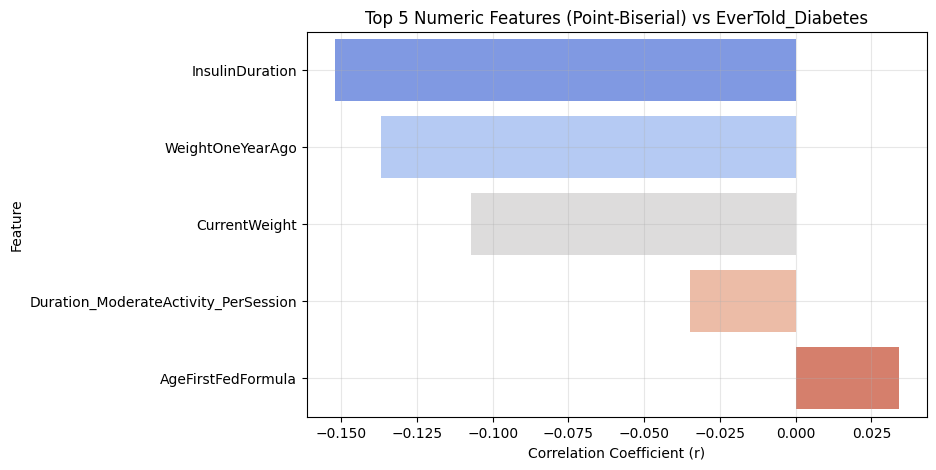

In [188]:

from scipy.stats import pointbiserialr

# # convert to numeric
merged_df_clean = merged_df.apply(pd.to_numeric, errors='coerce')


target_col = 'EverTold_Diabetes'

# Convert boolean target → numeric (0/1)
merged_df_clean[target_col] = merged_df_clean[target_col].astype(float)

# Drop rows with missing target 
merged_df_clean = merged_df_clean.dropna(subset=[target_col])


# num_cols = merged_df_clean.select_dtypes(include=['number']).columns.tolist()
# num_cols = [c for c in num_cols if c != target_col]

# Compute Point-Biserial correlation
corr_results = {}

for col in numerical_cols:
    clean_data = merged_df_clean[[col, target_col]].dropna()

    # Ensure it's not empty
    if clean_data.empty:
        continue

    unique_vals = clean_data[col].nunique()

    # Skip columns that are constant or binary (0/1)
    if isinstance(unique_vals, (pd.Series, pd.DataFrame)):
        unique_vals = unique_vals.values[0]
    if unique_vals <= 1 or unique_vals == 2:
        continue

    # Compute correlation safely
    try:
        corr, pval = pointbiserialr(clean_data[target_col], clean_data[col])
        if not np.isnan(corr):
            corr_results[col] = (round(corr, 3), round(pval, 4))
    except Exception as e:
        print(f"Skipping {col}: {e}")


corr_df = pd.DataFrame.from_dict(corr_results, orient='index', columns=['Correlation', 'p-value'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

print("Point-Biserial Correlation with EverTold_Diabetes (continuous vars only):")
display(corr_df)

# display
if not corr_df.empty:
    top = corr_df.copy()
    top['abs_corr'] = top['Correlation'].abs()
    top = top.sort_values('abs_corr', ascending=False).head(5).drop(columns='abs_corr')
    top_plot = top.reset_index().rename(columns={'index': 'Feature'})
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Correlation', y='Feature', data=top_plot, palette='coolwarm')
    plt.title("Top 5 Numeric Features (Point-Biserial) vs EverTold_Diabetes")
    plt.xlabel("Correlation Coefficient (r)")
    plt.ylabel("Feature")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("ℹ No suitable continuous variables found for correlation.")


Binary Categorical Pearson Correlations with Diabetes:


,Correlation,p-value
QuestionnaireModeFlag,0.061,0.0000
MealsDeliveredHome_Past12Months,0.049,0.0000
FirstTypeOfMilkFed_1,0.005,0.5909
CurrentlyTaking_BloodPressureMedication,-0.001,0.9459
ConfirmedHypertension_Visits,-0.045,0.0000
EverHad_Alcohol,-0.058,0.0000
EverTold_Prediabetes,-0.059,0.0000


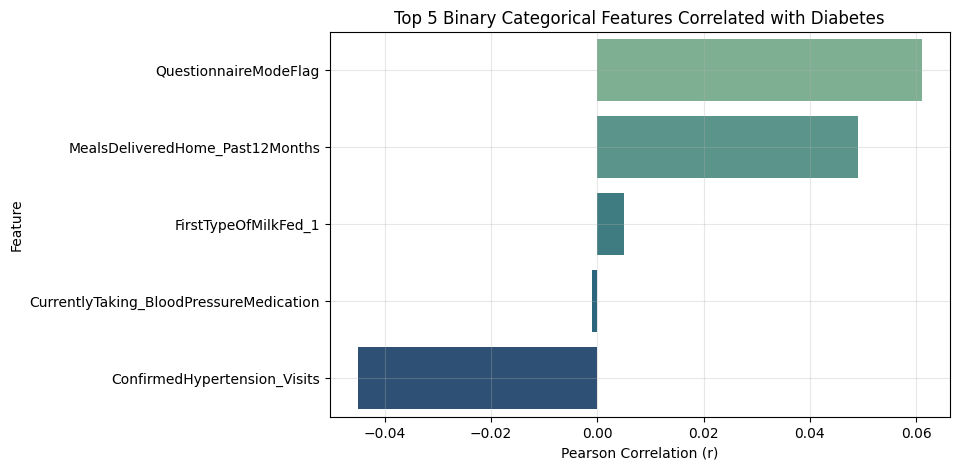

In [189]:

from scipy.stats import pearsonr

# Target column
target_col = 'EverTold_Diabetes'

# Identify binary numeric columns (exclude target and ID columns)
binary_cols = []
for col in merged_df_clean.columns:
    if col in [target_col, 'sequence_no']:
        continue
    col_data = merged_df_clean[col]
    if not pd.api.types.is_numeric_dtype(col_data):
        continue
    unique_vals = col_data.dropna().unique()
    if len(unique_vals) == 2:
        binary_cols.append(col)

# Compute Pearson Correlation + p-value
cat_corr = {}
for col in binary_cols:
    series = merged_df_clean[col]
    valid_idx = series.notna() & merged_df_clean[target_col].notna()
    x = merged_df_clean.loc[valid_idx, target_col]
    y = series.loc[valid_idx]

    if x.nunique() > 1 and y.nunique() > 1:
        try:
            r, p = pearsonr(x, y)
            if not np.isnan(r):
                cat_corr[col] = (round(r, 3), round(p, 4))
        except Exception as e:
            print(f"Skipping {col} due to error: {e}")

# Build dataframe
cat_corr_df = pd.DataFrame.from_dict(cat_corr, orient='index', columns=['Correlation', 'p-value'])
cat_corr_df = cat_corr_df.sort_values(by='Correlation', ascending=False)

print("\nBinary Categorical Pearson Correlations with Diabetes:")
display(cat_corr_df)

# Plot top 5 correlations
if not cat_corr_df.empty:
    top_categorical = cat_corr_df.head(5)
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Correlation', y=top_categorical.index, data=top_categorical, palette='crest')
    plt.title('Top 5 Binary Categorical Features Correlated with Diabetes')
    plt.xlabel('Pearson Correlation (r)')
    plt.ylabel('Feature')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No valid binary categorical correlations to plot.")


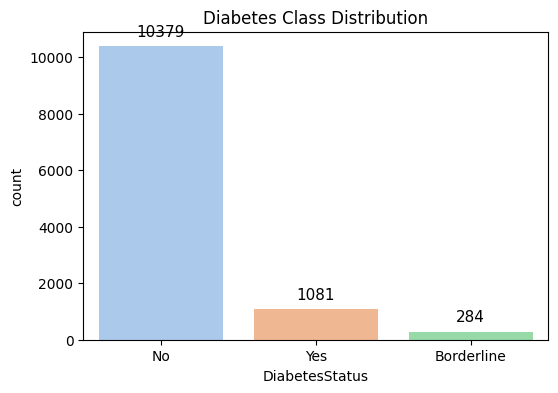

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map numeric codes + pd.NA to strings
diabetes_map = {
    1: "Yes",
    2: "No",
    3: "Borderline"
}

merged_df['DiabetesStatus'] = merged_df['EverTold_Diabetes'].apply(
    lambda x: diabetes_map.get(int(x), "Missing") if pd.notna(x) else "Missing"
)

plt.figure(figsize=(6,4))
ax = sns.countplot(x='DiabetesStatus', data=merged_df, palette='pastel')
plt.title("Diabetes Class Distribution")

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                xy=(p.get_x() + p.get_width() / 2, height), 
                xytext=(0, 5),  # 5 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=11)

plt.show()


#### Correlation Heatmap

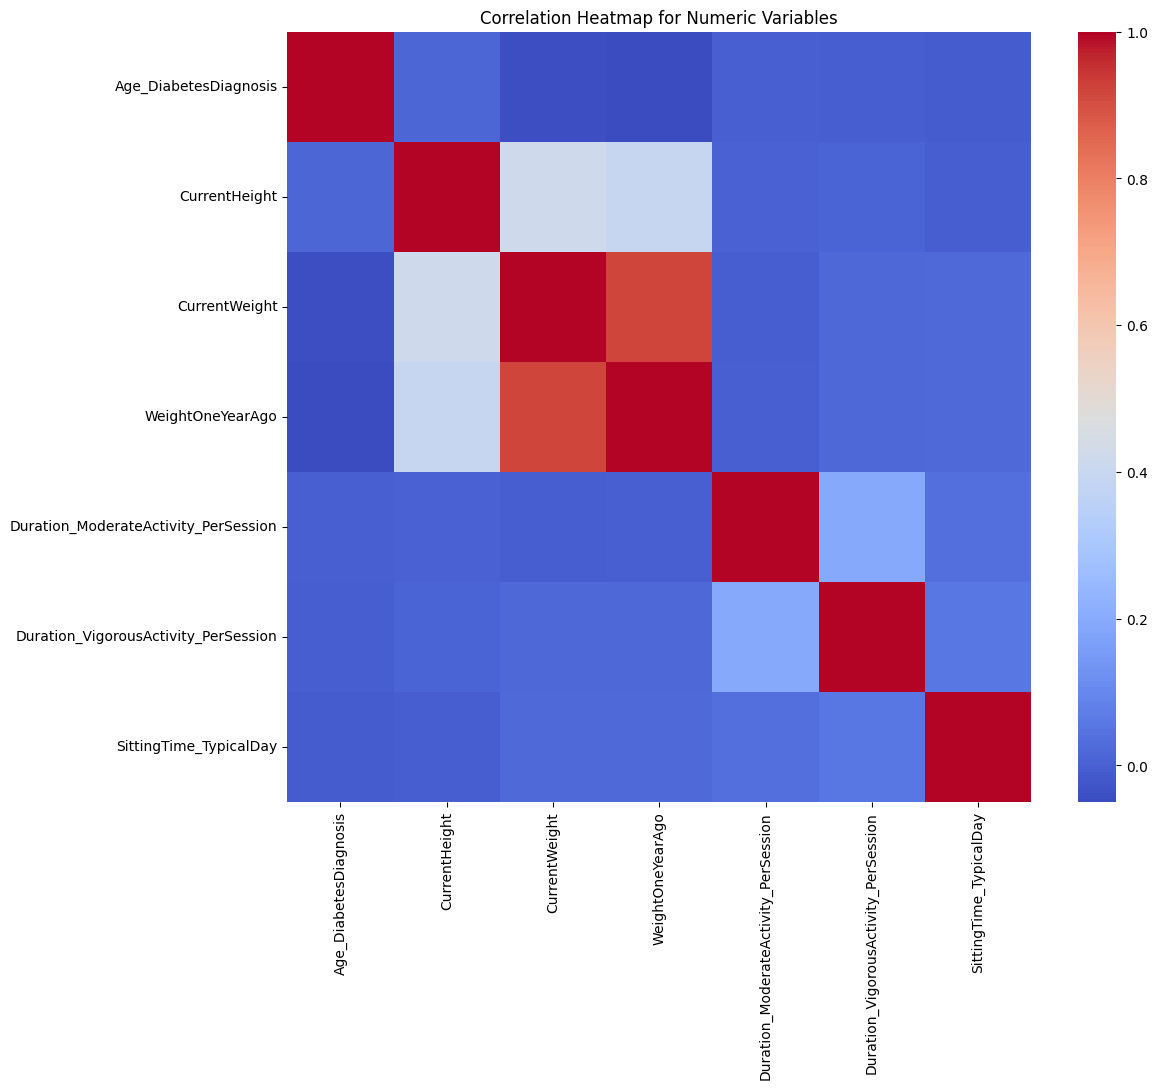

In [191]:
numeric_existing = [col for col in numeric_cols if col in merged_df.columns]

plt.figure(figsize=(12,10))
sns.heatmap(
    merged_df[numeric_existing].corr(),
    cmap="coolwarm",
    annot=False
)
plt.title("Correlation Heatmap for Numeric Variables")
plt.show()



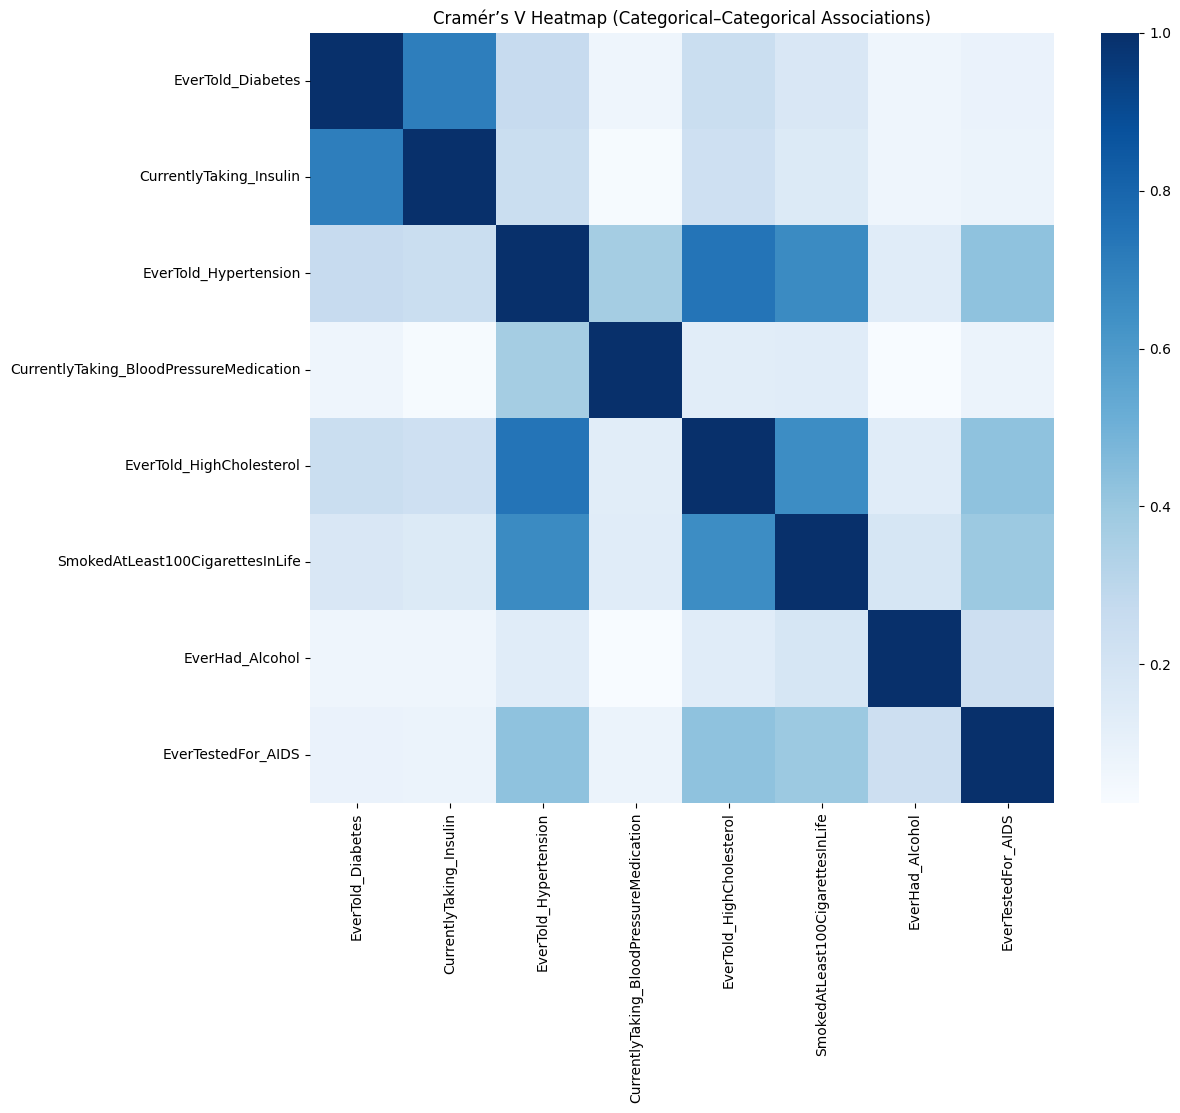

In [192]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r,k = confusion.shape
    return np.sqrt((chi2/n) / (min(k-1, r-1)))
categorical_existing = [col for col in categorical_cols if col in merged_df.columns]

cramers_results = pd.DataFrame(index=categorical_existing, columns=categorical_existing)

for col1 in categorical_existing:
    for col2 in categorical_existing:
        cramers_results.loc[col1, col2] = cramers_v(
            merged_df[col1].astype('category'),
            merged_df[col2].astype('category')
        )

plt.figure(figsize=(12,10))
sns.heatmap(cramers_results.astype(float), cmap="Blues", annot=False)
plt.title("Cramér’s V Heatmap (Categorical–Categorical Associations)")
plt.show()


In [193]:
from scipy.stats import mannwhitneyu

numeric_existing = [col for col in numeric_cols if col in merged_df.columns]
results_numeric = []

for col in numeric_existing:
    group1 = merged_df[merged_df['EverTold_Diabetes'] == 1][col].dropna()
    group2 = merged_df[merged_df['EverTold_Diabetes'] == 2][col].dropna()

    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    results_numeric.append([col, p])

pd.DataFrame(results_numeric, columns=['Feature', 'p-value']).sort_values("p-value")


,Feature,p-value
3,WeightOneYearAgo,3.767561e-58
0,Age_DiabetesDiagnosis,4.720151e-54
2,CurrentWeight,2.362729e-45
4,Duration_ModerateActivity_PerSession,1.211049e-08
5,Duration_VigorousActivity_PerSession,3.897897e-03
1,CurrentHeight,4.411829e-02
6,SittingTime_TypicalDay,1.157730e-01


#### p values redone- more accurate

In [194]:
from scipy.stats import chi2_contingency

results_cat = []

for col in categorical_existing:
    contingency = pd.crosstab(merged_df[col], merged_df['EverTold_Diabetes'])
    chi2, p, dof, ex = chi2_contingency(contingency)
    results_cat.append([col, p])

pd.DataFrame(results_cat, columns=['Feature', 'p-value']).sort_values("p-value")


,Feature,p-value
0,EverTold_Diabetes,0.000000e+00
1,CurrentlyTaking_Insulin,0.000000e+00
2,EverTold_Hypertension,0.000000e+00
4,EverTold_HighCholesterol,0.000000e+00
5,SmokedAtLeast100CigarettesInLife,1.153525e-154
7,EverTestedFor_AIDS,8.347069e-40
6,EverHad_Alcohol,2.392930e-12
3,CurrentlyTaking_BloodPressureMedication,4.297668e-12


### Set baseline

In [195]:
# Majority class baseline
majority_class = merged_df['EverTold_Diabetes'].mode()[0]
baseline_preds = [majority_class] * len(merged_df)

# Accuracy
accuracy = (merged_df['EverTold_Diabetes'] == baseline_preds).mean()
print(f"Majority class baseline accuracy: {accuracy:.4f}")

Majority class baseline accuracy: 0.8838


#### Balanced accuracy used as metric

Balanced Accuracy: 0.3333333333333333

Classification Report:
              precision    recall  f1-score   support

         Yes       0.00      0.00      0.00      1081
          No       0.88      1.00      0.94     10379
  Borderline       0.00      0.00      0.00       284

    accuracy                           0.88     11744
   macro avg       0.29      0.33      0.31     11744
weighted avg       0.78      0.88      0.83     11744



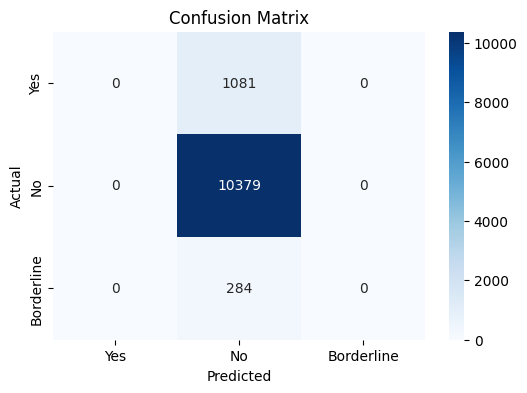

In [196]:
# 1. Balanced Accuracy 
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# True labels
y_true = merged_df['EverTold_Diabetes']
# Predicted labels (majority class)
y_pred = baseline_preds

balanced_acc = balanced_accuracy_score(y_true, y_pred)
print("Balanced Accuracy:", balanced_acc)

# 2. Classification Report 
print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=['Yes', 'No', 'Borderline']
))

# 3. Confusion Matrix 
cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Yes','No','Borderline'],
            yticklabels=['Yes','No','Borderline'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Simple Models

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, classification_report, 
    confusion_matrix, roc_auc_score, precision_recall_curve, auc
)


# Drop unnecessary columns
X = merged_df.drop(columns=['EverTold_Diabetes', 'DiabetesStatus', 'sequence_no','CurrentlyTaking_DiabeticPills','CurrentlyTaking_Insulin','BloodSugarTest_Last3Years','EverTold_Prediabetes','Age_DiabetesDiagnosis', 'InsulinDuration'])
y = merged_df['EverTold_Diabetes']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget class distribution:")
print(y.value_counts())



X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Preserve class distribution
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


# Feature Scaling (Important for Logistic Regression)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n Features scaled (mean=0, std=1)")


Features shape: (11744, 50)
Target shape: (11744,)

Target class distribution:
EverTold_Diabetes
2.0    10379
1.0     1081
3.0      284
Name: count, dtype: int64

Training set: 9395 samples
Test set: 2349 samples

 Features scaled (mean=0, std=1)


#### Logistic Regression
Input X = all numeric features + encoded categorical features

Output y = diabetes status (Yes / No / Borderline)

Predicts probability of each class, then picks the highest.

In [198]:
# 4. Train Logistic Regression Model

print("\n" + "="*60)
print("TRAINING LOGISTIC REGRESSION")
print("="*60)

log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',  # For 3-class problem (Yes/No/Borderline)
    solver='lbfgs',
    class_weight='balanced'  # Handle imbalance automatically
)

log_reg.fit(X_train_scaled, y_train)
print(" Model trained successfully!")


TRAINING LOGISTIC REGRESSION
 Model trained successfully!


In [199]:
# 5. Make Predictions
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)

# Probability predictions for ROC-AUC
y_pred_proba_train = log_reg.predict_proba(X_train_scaled)
y_pred_proba_test = log_reg.predict_proba(X_test_scaled)

# 6. Evaluate on Training Set

print("\n" + "="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)

train_balanced_acc = balanced_accuracy_score(y_train, y_pred_train)
train_f1_weighted = f1_score(y_train, y_pred_train, average='weighted')
train_f1_macro = f1_score(y_train, y_pred_train, average='macro')

print(f"Balanced Accuracy: {train_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {train_f1_weighted:.4f}")
print(f"F1 Score (Macro): {train_f1_macro:.4f}")

# 7. Evaluate on Test Set

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

print(f"Balanced Accuracy: {test_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {test_f1_weighted:.4f}")
print(f"F1 Score (Macro): {test_f1_macro:.4f}")



TRAINING SET PERFORMANCE
Balanced Accuracy: 0.5924
F1 Score (Weighted): 0.7534
F1 Score (Macro): 0.4439

TEST SET PERFORMANCE
Balanced Accuracy: 0.5963
F1 Score (Weighted): 0.7539
F1 Score (Macro): 0.4479



DETAILED CLASSIFICATION REPORT (TEST SET)
                  precision    recall  f1-score   support

  Diabetes (Yes)     0.3375    0.6296    0.4394       216
No Diabetes (No)     0.9740    0.6855    0.8046      2076
      Borderline     0.0557    0.4737    0.0996        57

        accuracy                         0.6752      2349
       macro avg     0.4557    0.5963    0.4479      2349
    weighted avg     0.8932    0.6752    0.7539      2349



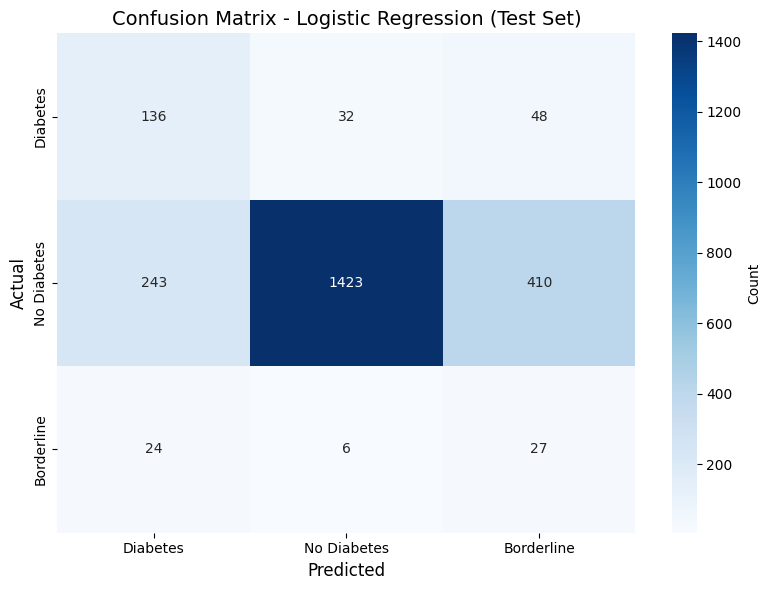

In [200]:

# 8. Classification Report


print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['Diabetes (Yes)', 'No Diabetes (No)', 'Borderline'],
    digits=4
))

# 9. Confusion Matrix

cm = confusion_matrix(y_test, y_pred_test, labels=[1, 2, 3])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    yticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - Logistic Regression (Test Set)", fontsize=14)
plt.tight_layout()
plt.show()



TOP 15 MOST IMPORTANT FEATURES
                                   Feature  Coefficient  Abs_Coefficient
         OccasionsWithHeavyDrinking_30Days    -0.813413         0.813413
                     EverTold_Hypertension    -0.641335         0.641335
     CurrentlyTaking_CholesterolMedication    -0.554533         0.554533
SchoolServesBreakfastsAtConstantCostsDaily    -0.393914         0.393914
                           LunchCostStatus     0.387888         0.387888
                          WeightOneYearAgo     0.340326         0.340326
            TriedToLoseWeight_Past12Months     0.325952         0.325952
                       SchoolServesLunches    -0.268020         0.268020
                             EverBreastfed     0.258775         0.258775
                     TotalCigarettesSmoked    -0.241424         0.241424
                  EverTold_HighCholesterol    -0.225385         0.225385
      Duration_ModerateActivity_PerSession     0.216574         0.216574
          SmokedAtL

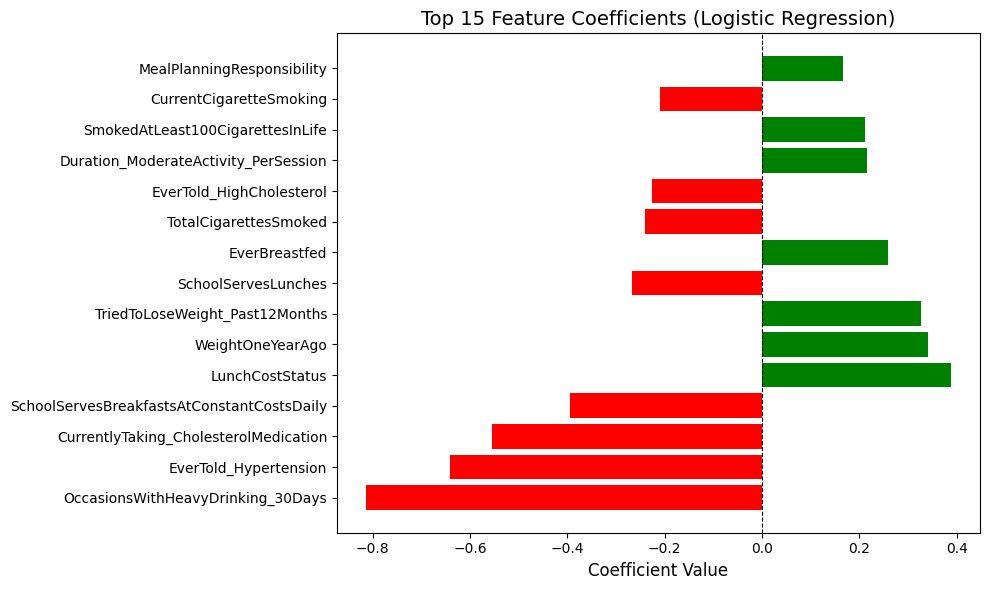

In [201]:

# 10. Feature Importance (Coefficients)

# Get feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]  # For multiclass, use first class
})

feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(15).to_string(index=False))

# Visualize top features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel("Coefficient Value", fontsize=12)
plt.title("Top 15 Feature Coefficients (Logistic Regression)", fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()


### ML Models

#### Random Forest
RF is an ensemble of decision trees.

Each tree is trained on a random subset of the data (bagging) and random subset of features.

Final prediction = majority vote of all trees.

Trees are non-linear models → can capture complex feature interactions.

In [202]:
from sklearn.ensemble import RandomForestClassifier

#Train Random Forest

print("\n" + "="*60)
print("TRAINING RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=200,              # Number of trees
    max_depth=15,                  # Max tree depth (prevent overfitting)
    min_samples_split=10,          # Min samples to split a node
    min_samples_leaf=5,            # Min samples in leaf node
    class_weight='balanced',       # Handle imbalanced classes
    random_state=42,
    n_jobs=-1,                     # Use all CPU cores
)

rf_model.fit(X_train, y_train)
print(" Random Forest model trained successfully!")



TRAINING RANDOM FOREST
 Random Forest model trained successfully!


In [203]:


y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Probability predictions
y_pred_proba_train = rf_model.predict_proba(X_train)
y_pred_proba_test = rf_model.predict_proba(X_test)



print("\n" + "="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)

train_balanced_acc = balanced_accuracy_score(y_train, y_pred_train)
train_f1_weighted = f1_score(y_train, y_pred_train, average='weighted')
train_f1_macro = f1_score(y_train, y_pred_train, average='macro')

print(f"Balanced Accuracy: {train_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {train_f1_weighted:.4f}")
print(f"F1 Score (Macro): {train_f1_macro:.4f}")



print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

print(f"Balanced Accuracy: {test_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {test_f1_weighted:.4f}")
print(f"F1 Score (Macro): {test_f1_macro:.4f}")




TRAINING SET PERFORMANCE
Balanced Accuracy: 0.9027
F1 Score (Weighted): 0.8956
F1 Score (Macro): 0.8029

TEST SET PERFORMANCE
Balanced Accuracy: 0.5116
F1 Score (Weighted): 0.8321
F1 Score (Macro): 0.4423



DETAILED CLASSIFICATION REPORT (TEST SET)
                  precision    recall  f1-score   support

  Diabetes (Yes)     0.3136    0.6852    0.4302       216
No Diabetes (No)     0.9494    0.8497    0.8968      2076
      Borderline     0.0000    0.0000    0.0000        57

        accuracy                         0.8140      2349
       macro avg     0.4210    0.5116    0.4423      2349
    weighted avg     0.8679    0.8140    0.8321      2349



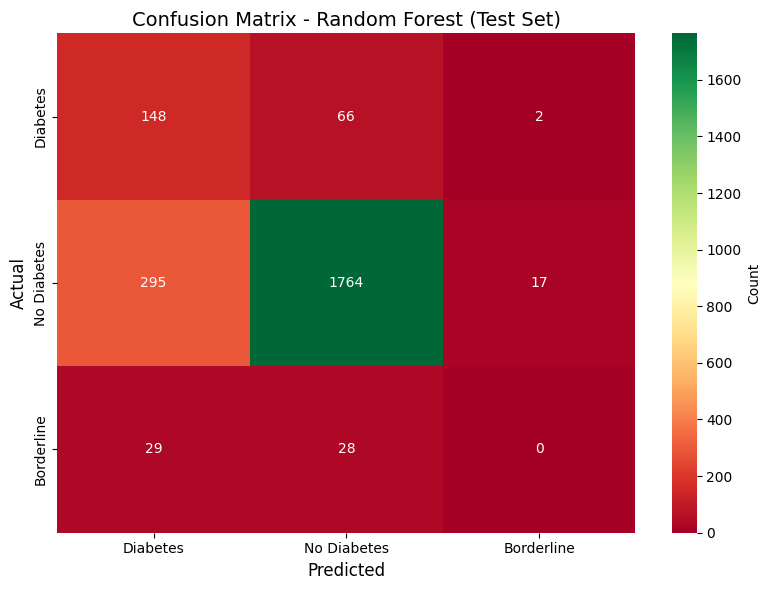

In [204]:

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['Diabetes (Yes)', 'No Diabetes (No)', 'Borderline'],
    digits=4
))


cm = confusion_matrix(y_test, y_pred_test, labels=[1, 2, 3])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='RdYlGn',
    xticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    yticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - Random Forest (Test Set)", fontsize=14)
plt.tight_layout()
plt.show()


TOP 20 MOST IMPORTANT FEATURES
                                Feature  Importance
                       WeightOneYearAgo    0.089593
                          CurrentWeight    0.087831
                  EverTold_Hypertension    0.067677
  CurrentlyTaking_CholesterolMedication    0.065516
                          CurrentHeight    0.062190
                 SittingTime_TypicalDay    0.057102
               EverTold_HighCholesterol    0.047881
   Duration_ModerateActivity_PerSession    0.043792
   AlcoholConsumptionFrequency_12Months    0.041941
       SmokedAtLeast100CigarettesInLife    0.039248
         TriedToLoseWeight_Past12Months    0.031975
   Duration_VigorousActivity_PerSession    0.031128
                 MealPreparationSharing    0.029369
                    FoodShoppingSharing    0.026443
MoreThanSpecificNumberOfDrinksFrequency    0.025743
             FoodShoppingResponsibility    0.025447
             MealPlanningResponsibility    0.022349
                     EverTestedF

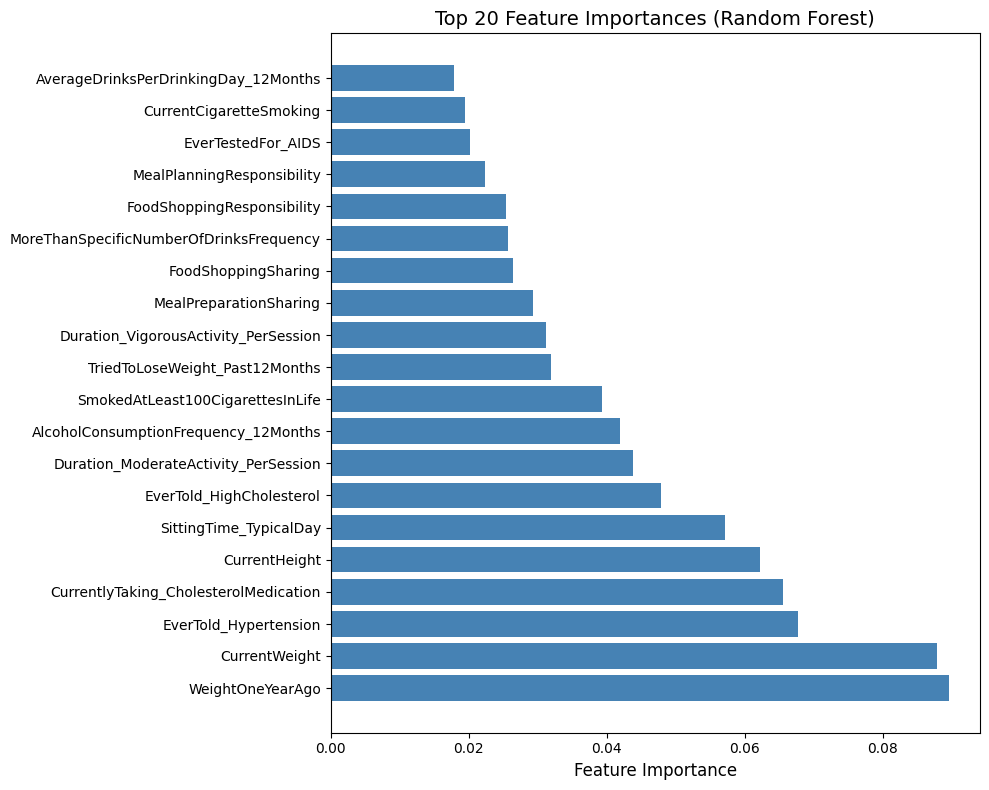

In [205]:


# feature Importance (from Tree Splits)


feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(20).to_string(index=False))

# Visualize top features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top 20 Feature Importances (Random Forest)", fontsize=14)
plt.tight_layout()
plt.show()

#### XGBoost
Boosting = training trees sequentially, where each tree corrects the mistakes of the previous.

Focuses on hard-to-predict samples.

Gradient Boosting = minimizes a loss function using gradient descent.

Model learns feature combinations that predict minority classes

In [206]:
# In a notebook cell
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [207]:

# Remap target classes from [1, 2, 3] to [0, 1, 2]

# Create a mapping dictionary
class_mapping = {1: 0, 2: 1, 3: 2}
reverse_mapping = {0: 1, 1: 2, 2: 3}

# Remap y_train and y_test
y_train_remapped = y_train.map(class_mapping)
y_test_remapped = y_test.map(class_mapping)

print("Original classes in y_train:", y_train.unique())
print("Remapped classes in y_train:", y_train_remapped.unique())
print("\nOriginal classes in y_test:", y_test.unique())
print("Remapped classes in y_test:", y_test_remapped.unique())


#Train XGBoost (with remapped labels)

import xgboost as xgb

print("\n" + "="*60)
print("TRAINING XGBOOST")
print("="*60)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,              # Number of boosting rounds
    max_depth=6,                   # Maximum tree depth
    learning_rate=0.1,             # Learning rate (shrinkage)
    subsample=0.8,                 # Subsample ratio for trees
    colsample_bytree=0.8,          # Feature subsample ratio
    random_state=42,
    n_jobs=-1,                     # Use all CPU cores
    eval_metric='mlogloss',        # For multiclass classification
    verbosity=0
)

xgb_model.fit(
    X_train, y_train_remapped,
    eval_set=[(X_test, y_test_remapped)],
    verbose=False
)

print("✅ XGBoost model trained successfully!")


Original classes in y_train: [2. 1. 3.]
Remapped classes in y_train: [1 0 2]

Original classes in y_test: [2. 1. 3.]
Remapped classes in y_test: [1 0 2]

TRAINING XGBOOST
✅ XGBoost model trained successfully!


In [208]:


y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

# Remap predictions back to original labels [1, 2, 3]
y_pred_xgb_train = pd.Series(y_pred_xgb_train).map(reverse_mapping).values
y_pred_xgb_test = pd.Series(y_pred_xgb_test).map(reverse_mapping).values

y_pred_proba_xgb_train = xgb_model.predict_proba(X_train)
y_pred_proba_xgb_test = xgb_model.predict_proba(X_test)


# Evaluate on Training Set


print("\n" + "="*60)
print("XGBOOST - TRAINING SET PERFORMANCE")
print("="*60)

xgb_train_balanced_acc = balanced_accuracy_score(y_train, y_pred_xgb_train)
xgb_train_f1_weighted = f1_score(y_train, y_pred_xgb_train, average='weighted')
xgb_train_f1_macro = f1_score(y_train, y_pred_xgb_train, average='macro')

print(f"Balanced Accuracy: {xgb_train_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {xgb_train_f1_weighted:.4f}")
print(f"F1 Score (Macro): {xgb_train_f1_macro:.4f}")


#  Evaluate on Test Set


print("\n" + "="*60)
print("XGBOOST - TEST SET PERFORMANCE")
print("="*60)

xgb_test_balanced_acc = balanced_accuracy_score(y_test, y_pred_xgb_test)
xgb_test_f1_weighted = f1_score(y_test, y_pred_xgb_test, average='weighted')
xgb_test_f1_macro = f1_score(y_test, y_pred_xgb_test, average='macro')

print(f"Balanced Accuracy: {xgb_test_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {xgb_test_f1_weighted:.4f}")
print(f"F1 Score (Macro): {xgb_test_f1_macro:.4f}")



XGBOOST - TRAINING SET PERFORMANCE
Balanced Accuracy: 0.7621
F1 Score (Weighted): 0.9608
F1 Score (Macro): 0.8411

XGBOOST - TEST SET PERFORMANCE
Balanced Accuracy: 0.4068
F1 Score (Weighted): 0.8588
F1 Score (Macro): 0.4216



DETAILED CLASSIFICATION REPORT (TEST SET)
                  precision    recall  f1-score   support

  Diabetes (Yes)     0.4907    0.2454    0.3272       216
No Diabetes (No)     0.9032    0.9750    0.9377      2076
      Borderline     0.0000    0.0000    0.0000        57

        accuracy                         0.8842      2349
       macro avg     0.4646    0.4068    0.4216      2349
    weighted avg     0.8433    0.8842    0.8588      2349



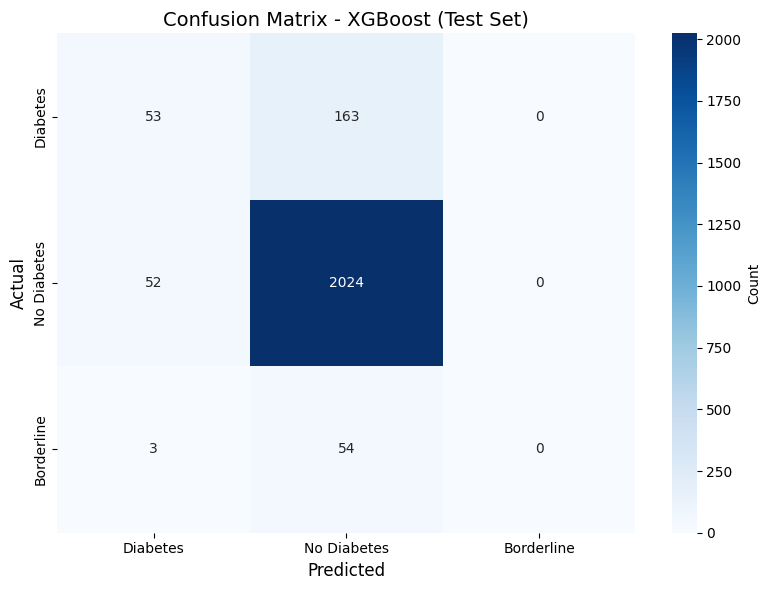

In [209]:



print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(
    y_test, y_pred_xgb_test,
    target_names=['Diabetes (Yes)', 'No Diabetes (No)', 'Borderline'],
    digits=4
))



cm_xgb = confusion_matrix(y_test, y_pred_xgb_test, labels=[1, 2, 3])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_xgb, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    yticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - XGBoost (Test Set)", fontsize=14)
plt.tight_layout()
plt.show()


TOP 20 XGBOOST FEATURE IMPORTANCES
                                Feature  Importance
  CurrentlyTaking_CholesterolMedication    0.180521
                  EverTold_Hypertension    0.110843
       SmokedAtLeast100CigarettesInLife    0.037546
               EverTold_HighCholesterol    0.032600
        MealsDeliveredHome_Past12Months    0.025527
                        EverHad_Alcohol    0.024390
                       WeightOneYearAgo    0.022798
   Duration_VigorousActivity_PerSession    0.021808
MoreThanSpecificNumberOfDrinksFrequency    0.020477
   AlcoholConsumptionFrequency_12Months    0.020259
CurrentlyTaking_BloodPressureMedication    0.020199
             FoodShoppingResponsibility    0.020028
         TriedToLoseWeight_Past12Months    0.019641
                          CurrentWeight    0.019256
      OccasionsWithHeavyDrinking_30Days    0.019087
         MoreThan8DrinksPerDay_12Months    0.018506
                CurrentCigaretteSmoking    0.018504
                          Cu

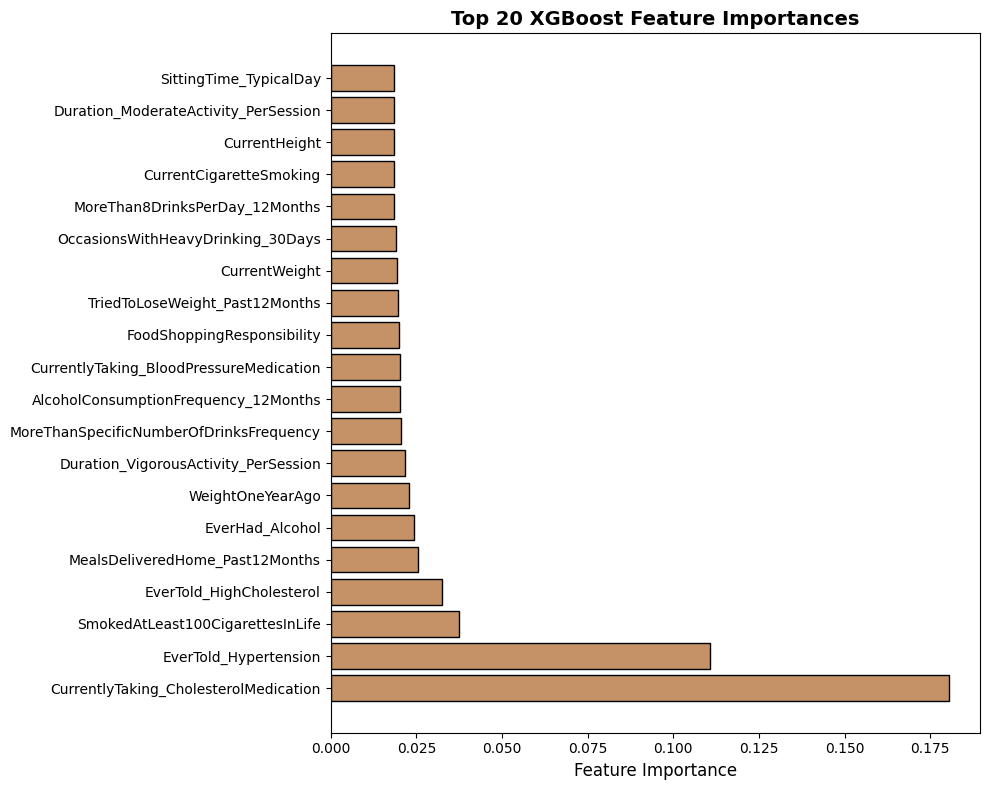

In [210]:
# Feature Importance


xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
})
xgb_importance = xgb_importance.sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 20 XGBOOST FEATURE IMPORTANCES")
print("="*60)
print(xgb_importance.head(20).to_string(index=False))

# Visualize top 20 features
plt.figure(figsize=(10, 8))
top_xgb = xgb_importance.head(20)
plt.barh(range(len(top_xgb)), top_xgb['Importance'], color="#C49266", edgecolor='black')
plt.yticks(range(len(top_xgb)), top_xgb['Feature'], fontsize=10)
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top 20 XGBoost Feature Importances", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### SVM
Finds a hyperplane that best separates classes in feature space.

Maximizes margin (distance between hyperplane and nearest points).
Input = all features scaled


Output = predicted diabetes class

In [211]:

from sklearn.svm import SVC


print("\n" + "="*60)
print("TRAINING SVM (RBF KERNEL)")
print("="*60)

svm_model = SVC(
    kernel='rbf',                   # Radial Basis Function (non-linear)
    C=1.0,                          # Regularization parameter
    gamma='scale',                  # Kernel coefficient
    class_weight='balanced',        # Handle class imbalance
    probability=True,               # Enable probability estimates
    random_state=42,
    verbose=0
)

svm_model.fit(X_train_scaled, y_train)
print(" SVM model trained successfully!")



TRAINING SVM (RBF KERNEL)
 SVM model trained successfully!


In [212]:


y_pred_svm_train = svm_model.predict(X_train_scaled)
y_pred_svm_test = svm_model.predict(X_test_scaled)

y_pred_proba_svm_train = svm_model.predict_proba(X_train_scaled)
y_pred_proba_svm_test = svm_model.predict_proba(X_test_scaled)



print("\n" + "="*60)
print("SVM - TRAINING SET PERFORMANCE")
print("="*60)

svm_train_balanced_acc = balanced_accuracy_score(y_train, y_pred_svm_train)
svm_train_f1_weighted = f1_score(y_train, y_pred_svm_train, average='weighted')
svm_train_f1_macro = f1_score(y_train, y_pred_svm_train, average='macro')

print(f"Balanced Accuracy: {svm_train_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {svm_train_f1_weighted:.4f}")
print(f"F1 Score (Macro): {svm_train_f1_macro:.4f}")


print("\n" + "="*60)
print("SVM - TEST SET PERFORMANCE")
print("="*60)

svm_test_balanced_acc = balanced_accuracy_score(y_test, y_pred_svm_test)
svm_test_f1_weighted = f1_score(y_test, y_pred_svm_test, average='weighted')
svm_test_f1_macro = f1_score(y_test, y_pred_svm_test, average='macro')

print(f"Balanced Accuracy: {svm_test_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {svm_test_f1_weighted:.4f}")
print(f"F1 Score (Macro): {svm_test_f1_macro:.4f}")



SVM - TRAINING SET PERFORMANCE
Balanced Accuracy: 0.7256
F1 Score (Weighted): 0.7956
F1 Score (Macro): 0.5101

SVM - TEST SET PERFORMANCE
Balanced Accuracy: 0.5444
F1 Score (Weighted): 0.7797
F1 Score (Macro): 0.4404



DETAILED CLASSIFICATION REPORT (TEST SET)
                  precision    recall  f1-score   support

  Diabetes (Yes)     0.2881    0.6296    0.3953       216
No Diabetes (No)     0.9673    0.7404    0.8387      2076
      Borderline     0.0521    0.2632    0.0870        57

        accuracy                         0.7186      2349
       macro avg     0.4358    0.5444    0.4404      2349
    weighted avg     0.8826    0.7186    0.7797      2349



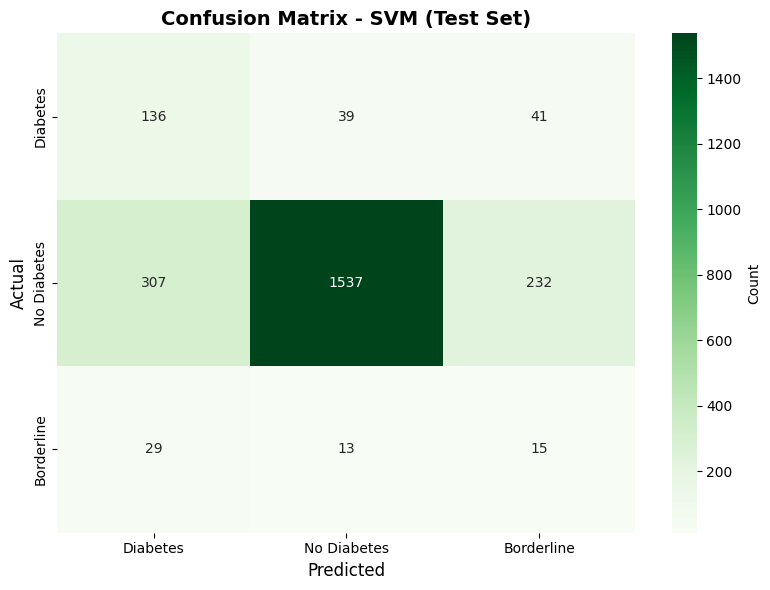


SVM MODEL DETAILS
Number of Support Vectors: 6073
Percentage of Training Data as SVs: 64.64%
Number of Features: 50
Kernel: RBF (Radial Basis Function)
Classes: [1. 2. 3.]


In [213]:


print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(
    y_test, y_pred_svm_test,
    target_names=['Diabetes (Yes)', 'No Diabetes (No)', 'Borderline'],
    digits=4
))


cm_svm = confusion_matrix(y_test, y_pred_svm_test, labels=[1, 2, 3])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_svm, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    yticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - SVM (Test Set)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



n_support_vectors = len(svm_model.support_vectors_)
n_features = X_train_scaled.shape[1]

print("\n" + "="*60)
print("SVM MODEL DETAILS")
print("="*60)
print(f"Number of Support Vectors: {n_support_vectors}")
print(f"Percentage of Training Data as SVs: {n_support_vectors/X_train_scaled.shape[0]*100:.2f}%")
print(f"Number of Features: {n_features}")
print(f"Kernel: RBF (Radial Basis Function)")
print(f"Classes: {svm_model.classes_}")

#### KNN
KNN is a distance-based model.

For a new sample, it finds the k closest training points (neighbors).

Assigns the class most common among neighbors.


FINDING OPTIMAL K VALUE
K= 3 | Train Balanced Acc: 0.5132 | Test Balanced Acc: 0.3961
K= 5 | Train Balanced Acc: 0.4373 | Test Balanced Acc: 0.3866
K= 7 | Train Balanced Acc: 0.4073 | Test Balanced Acc: 0.3692
K= 9 | Train Balanced Acc: 0.3910 | Test Balanced Acc: 0.3589
K=11 | Train Balanced Acc: 0.3769 | Test Balanced Acc: 0.3588
K=13 | Train Balanced Acc: 0.3662 | Test Balanced Acc: 0.3520
K=15 | Train Balanced Acc: 0.3585 | Test Balanced Acc: 0.3525
K=17 | Train Balanced Acc: 0.3531 | Test Balanced Acc: 0.3502
K=19 | Train Balanced Acc: 0.3536 | Test Balanced Acc: 0.3461
K=21 | Train Balanced Acc: 0.3484 | Test Balanced Acc: 0.3452
K=23 | Train Balanced Acc: 0.3460 | Test Balanced Acc: 0.3435
K=25 | Train Balanced Acc: 0.3452 | Test Balanced Acc: 0.3406
K=27 | Train Balanced Acc: 0.3426 | Test Balanced Acc: 0.3421
K=29 | Train Balanced Acc: 0.3392 | Test Balanced Acc: 0.3392


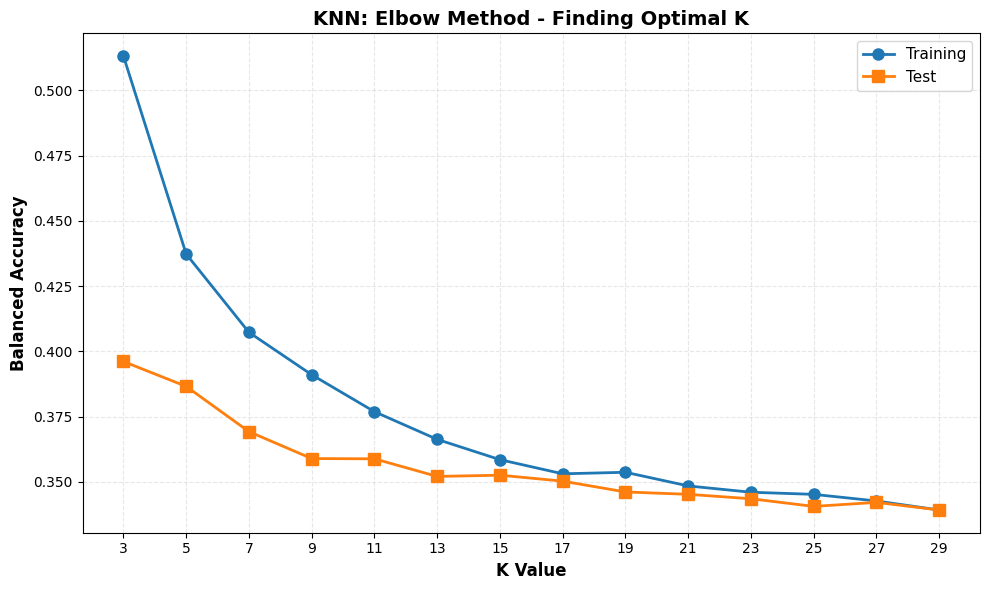

In [214]:

#Find Optimal K Value (Elbow Method)

from sklearn.neighbors import KNeighborsClassifier


print("\n" + "="*60)
print("FINDING OPTIMAL K VALUE")
print("="*60)

k_values = range(3, 31, 2)  # Test odd values from 3 to 29
train_scores = []
test_scores = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_temp.fit(X_train_scaled, y_train)
    
    train_score = balanced_accuracy_score(y_train, knn_temp.predict(X_train_scaled))
    test_score = balanced_accuracy_score(y_test, knn_temp.predict(X_test_scaled))
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"K={k:2d} | Train Balanced Acc: {train_score:.4f} | Test Balanced Acc: {test_score:.4f}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, marker='o', label='Training', linewidth=2, markersize=8)
plt.plot(k_values, test_scores, marker='s', label='Test', linewidth=2, markersize=8)
plt.xlabel('K Value', fontsize=12, fontweight='bold')
plt.ylabel('Balanced Accuracy', fontsize=12, fontweight='bold')
plt.title('KNN: Elbow Method - Finding Optimal K', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

In [215]:
# Find best K
best_k_idx = np.argmax(test_scores)
best_k = list(k_values)[best_k_idx]
best_test_score = test_scores[best_k_idx]

print(f"\nOptimal K: {best_k}")
print(f"   Test Balanced Accuracy: {best_test_score:.4f}")



Optimal K: 3
   Test Balanced Accuracy: 0.3961


In [216]:
# Train KNN with Optimal K


print("\n" + "="*60)
print(f"TRAINING KNN (K={best_k})")
print("="*60)

knn_model = KNeighborsClassifier(
    n_neighbors=best_k,             # Optimal K from elbow method
    weights='distance',             # Weight by inverse distance
    metric='minkowski',             # Minkowski distance (euclidean when p=2)
    p=2,                            # Euclidean distance
    n_jobs=-1                       # Use all CPU cores
)

knn_model.fit(X_train_scaled, y_train)
print("✅ KNN model trained successfully!")



y_pred_knn_train = knn_model.predict(X_train_scaled)
y_pred_knn_test = knn_model.predict(X_test_scaled)

y_pred_proba_knn_train = knn_model.predict_proba(X_train_scaled)
y_pred_proba_knn_test = knn_model.predict_proba(X_test_scaled)
# Evaluate on Training Set

print("\n" + "="*60)
print("KNN - TRAINING SET PERFORMANCE")
print("="*60)

knn_train_balanced_acc = balanced_accuracy_score(y_train, y_pred_knn_train)
knn_train_f1_weighted = f1_score(y_train, y_pred_knn_train, average='weighted')
knn_train_f1_macro = f1_score(y_train, y_pred_knn_train, average='macro')

print(f"Balanced Accuracy: {knn_train_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {knn_train_f1_weighted:.4f}")
print(f"F1 Score (Macro): {knn_train_f1_macro:.4f}")

# Evaluate on Test Set

print("\n" + "="*60)
print("KNN - TEST SET PERFORMANCE")
print("="*60)

knn_test_balanced_acc = balanced_accuracy_score(y_test, y_pred_knn_test)
knn_test_f1_weighted = f1_score(y_test, y_pred_knn_test, average='weighted')
knn_test_f1_macro = f1_score(y_test, y_pred_knn_test, average='macro')

print(f"Balanced Accuracy: {knn_test_balanced_acc:.4f}")
print(f"F1 Score (Weighted): {knn_test_f1_weighted:.4f}")
print(f"F1 Score (Macro): {knn_test_f1_macro:.4f}")


TRAINING KNN (K=3)
✅ KNN model trained successfully!

KNN - TRAINING SET PERFORMANCE
Balanced Accuracy: 0.9878
F1 Score (Weighted): 0.9987
F1 Score (Macro): 0.9936

KNN - TEST SET PERFORMANCE
Balanced Accuracy: 0.3884
F1 Score (Weighted): 0.8459
F1 Score (Macro): 0.3980



DETAILED CLASSIFICATION REPORT (TEST SET)
                  precision    recall  f1-score   support

  Diabetes (Yes)     0.3761    0.2037    0.2643       216
No Diabetes (No)     0.8999    0.9615    0.9297      2076
      Borderline     0.0000    0.0000    0.0000        57

        accuracy                         0.8685      2349
       macro avg     0.4253    0.3884    0.3980      2349
    weighted avg     0.8299    0.8685    0.8459      2349



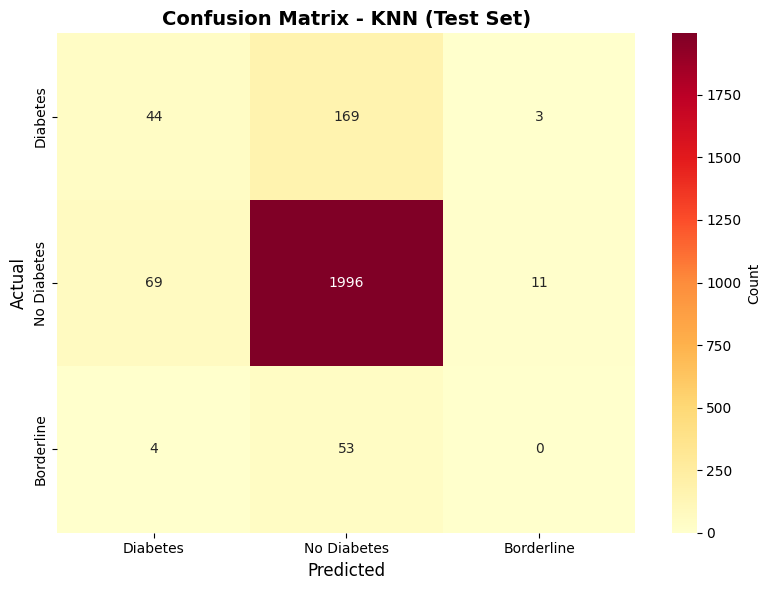

In [217]:


print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(
    y_test, y_pred_knn_test,
    target_names=['Diabetes (Yes)', 'No Diabetes (No)', 'Borderline'],
    digits=4
))



cm_knn = confusion_matrix(y_test, y_pred_knn_test, labels=[1, 2, 3])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_knn, 
    annot=True, 
    fmt='d', 
    cmap='YlOrRd',
    xticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    yticklabels=['Diabetes', 'No Diabetes', 'Borderline'],
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - KNN (Test Set)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Models comparison

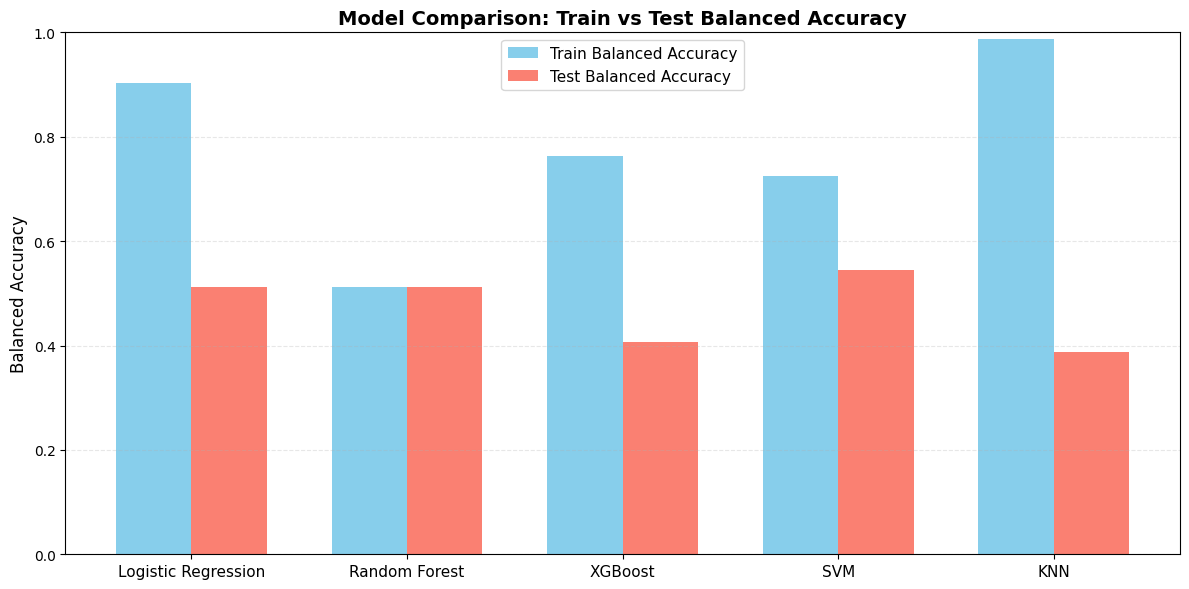

In [218]:
# compare models train and test balanced accuracy
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN']
train_scores = [train_balanced_acc, test_balanced_acc, xgb_train_balanced_acc, svm_train_balanced_acc, knn_train_balanced_acc]
test_scores = [test_balanced_acc, test_balanced_acc, xgb_test_balanced_acc, svm_test_balanced_acc, knn_test_balanced_acc]
x = np.arange(len(models))
width = 0.35
plt.figure(figsize=(12,6))
plt.bar(x - width/2, train_scores, width, label='Train Balanced Accuracy', color='skyblue')
plt.bar(x + width/2, test_scores, width, label='Test Balanced Accuracy',
        color='salmon')
plt.ylabel('Balanced Accuracy', fontsize=12)
plt.title('Model Comparison: Train vs Test Balanced Accuracy', fontsize=14, fontweight='bold')
plt.xticks(x, models, fontsize=11)
plt.ylim(0, 1)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()